<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/new_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax

In [9]:
# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    r2_values = []
    for i in range(len(W_all)):
        Y_pred = X_wins[i] @ W_all[i]
        ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
        ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        r2_values.append(r2)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [jnp.array(r2_values)],
        'method_used': f'jax_{constraint_method}'
    }


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows(X, window_size, stride)
                Y_wins = create_windows(residual, window_size, stride)
                W_layer = jnp.stack([solve_ols(X_wins[i], Y_wins[i])
                                   for i in range(len(X_wins))])

                # Compute R²
                r2_values = []
                for i in range(len(W_layer)):
                    Y_pred = X_wins[i] @ W_layer[i]
                    ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
                    ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_values.append(r2)

                results = {
                    'W_all': W_layer,
                    'r2': [jnp.array(r2_values)]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }

Running example...

Unified Sliding Regression Extended
  Method: jax
  Data: 1256 samples, 7 features, 168 outputs
  Windows: requested size 200, stride 150
  Countries: 12  Tenors: 14

Phase 1: Discovering zero patterns...
  Effective windows: 8 (size 200, stride 150)
  Discovered 121 zeros (10.3% sparsity)

Phase 2: Applying jax regression...

Completed in 8.049 seconds
  Zero violations: max=nan, count=3
  Offset violations: max=1.47e+01
  Fixed violations: max=2.98e-08
  Positive constraint violations: max=7.14e-01
  Negative constraint violations: max=2.61e-01
  Mean R²: nan


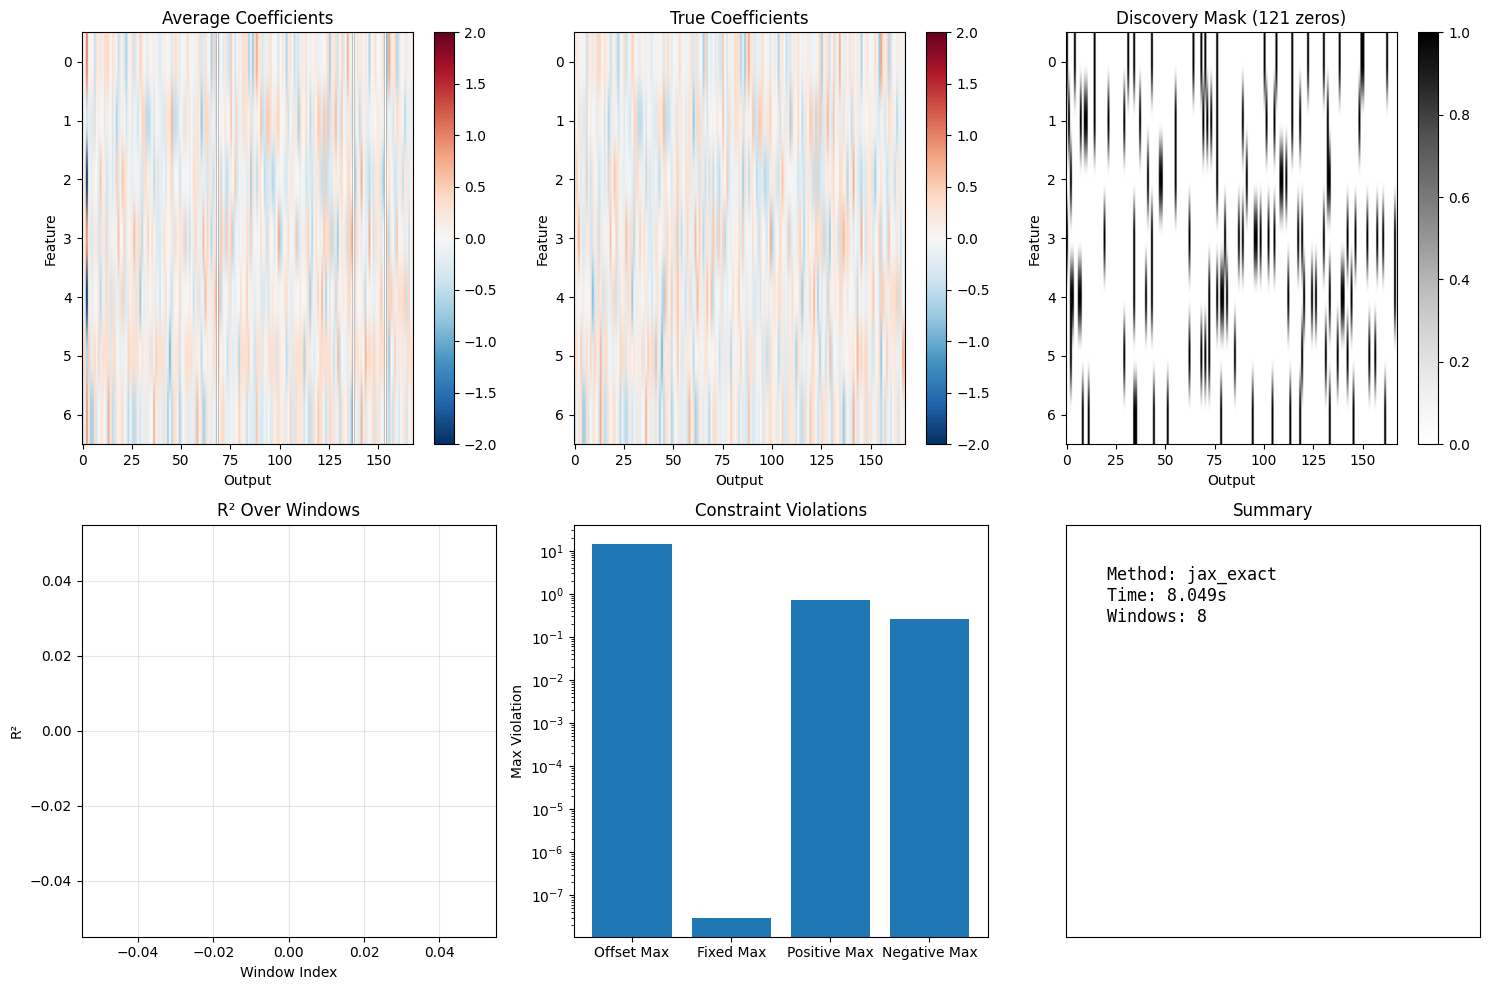

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


# =============================== WINDOWING ===============================

def create_windows(data, window_size, stride):
    """Create sliding windows, guaranteeing >=1 window (data unchanged)."""
    n_samples = int(data.shape[0])
    if stride <= 0:
        raise ValueError("stride must be > 0")

    # If the requested window is longer than the data, clamp to full length
    eff_window = min(int(window_size), n_samples)

    if n_samples <= eff_window:
        # One window: the whole series
        return jnp.array(data[None, :eff_window, ...])

    n_windows = (n_samples - eff_window) // stride + 1
    if n_windows <= 0:
        # One window: last eff_window samples
        start = n_samples - eff_window
        return jnp.array(data[None, start:start+eff_window, ...])

    idx0 = np.arange(n_windows)[:, None] * stride
    idx1 = np.arange(eff_window)[None, :]
    indices = idx0 + idx1
    return jnp.array(data[indices])


def create_windows_vectorized(data, window_size, stride):
    """Alias to create_windows; kept for compatibility."""
    return create_windows(data, window_size, stride)


# ============================ INDEX & PLANNER ============================

def output_index(c: int, t: int, n_tenors: int) -> int:
    return c * n_tenors + t

def output_ct_from_j(j: int, n_tenors: int):
    return (j // n_tenors, j % n_tenors)

def output_index_from_lists(country_idx: int, tenor_idx: int, tenor_list) -> int:
    """(country_pos, tenor_pos) -> flat output index, country-major then tenor."""
    return country_idx * len(tenor_list) + tenor_idx

def output_ct_from_j_using_lists(j: int, tenor_list):
    """flat output index -> (country_pos, tenor_pos)."""
    n_tenors = len(tenor_list)
    return (j // n_tenors, j % n_tenors)


def _normalize_selector(sel, max_len):
    if sel is None or sel == 'all':
        return list(range(max_len))
    if isinstance(sel, slice):
        return list(range(*sel.indices(max_len)))
    if isinstance(sel, range):
        return list(sel)
    return sorted(set(int(x) for x in sel))

def build_per_output_constraints_from_lists(country_list, tenor_list, n_features, constraints_config):
    """
    Expand country/tenor-scoped rules into per-output constraints.
    country_list / tenor_list can be strings or ints; positions define indices.
    """
    n_countries, n_tenors = len(country_list), len(tenor_list)
    n_outputs = n_countries * n_tenors
    per_output = {j: {'offset_pairs': [], 'fixed': [], 'positive': [], 'negative': [], 'zeros': []}
                  for j in range(n_outputs)}
    if constraints_config is None:
        constraints_config = {}

    def _normalize_selector(sel, max_len):
        if sel is None or sel == 'all':
            return list(range(max_len))
        if isinstance(sel, slice):
            return list(range(*sel.indices(max_len)))
        if isinstance(sel, range):
            return list(sel)
        return sorted(set(int(x) for x in sel))

    # Backward compatible globals
    glob_offsets = constraints_config.get('offset_indices', None)
    if glob_offsets is not None:
        if isinstance(glob_offsets, tuple):
            glob_offsets = [glob_offsets]
        for j in range(n_outputs):
            per_output[j]['offset_pairs'].extend(glob_offsets)

    glob_fixed = constraints_config.get('fixed_constraints', None)
    if glob_fixed is not None:
        for j in range(n_outputs):
            per_output[j]['fixed'].extend(glob_fixed)

    glob_pos = constraints_config.get('positive_constraints', None)
    if glob_pos is not None:
        for j in range(n_outputs):
            per_output[j]['positive'].extend(glob_pos)

    glob_neg = constraints_config.get('negative_constraints', None)
    if glob_neg is not None:
        for j in range(n_outputs):
            per_output[j]['negative'].extend(glob_neg)

    # Country/tenor-scoped
    cr = constraints_config.get('country_rules', {})

    for rule in cr.get('offset', []):
        i1, i2 = rule['pair']
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['offset_pairs'].append((int(i1), int(i2)))

    for rule in cr.get('fixed', []):
        idx, val = int(rule['idx']), float(rule['value'])
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['fixed'].append((idx, val))

    for rule in cr.get('sign', []):
        pos = [int(x) for x in rule.get('positive', [])]
        neg = [int(x) for x in rule.get('negative', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['positive'].extend(pos)
                per_output[j]['negative'].extend(neg)

    for rule in cr.get('zero', []):
        idxs = [int(x) for x in rule.get('indices', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'),    n_tenors)
        for ci in countries:
            for ti in tenors:
                j = output_index_from_lists(ci, ti, tenor_list)
                per_output[j]['zeros'].extend(idxs)

    # Dedup & bounds
    for j in range(n_outputs):
        d = per_output[j]
        d['offset_pairs'] = list({tuple(x) for x in d['offset_pairs']})
        d['fixed']        = list({(i, float(v)) for (i, v) in d['fixed']})
        d['positive']     = sorted(set(d['positive']))
        d['negative']     = sorted(set(d['negative']))
        d['zeros']        = sorted(set(d['zeros']))
        for i in d['positive'] + d['negative'] + d['zeros'] + [p for pair in d['offset_pairs'] for p in pair] + [i for (i, _) in d['fixed']]:
            if not (0 <= i < n_features):
                raise ValueError(f"Feature index {i} out of range for output {j}")

    return per_output


def build_per_output_constraints(n_countries, n_tenors, n_features, constraints_config):
    """
    Expand country/tenor-scoped rules into per-output constraints.
    Returns dict j -> {'offset_pairs','fixed','positive','negative','zeros'}.
    """
    n_outputs = n_countries * n_tenors
    per_output = {j: {'offset_pairs': [], 'fixed': [], 'positive': [], 'negative': [], 'zeros': []}
                  for j in range(n_outputs)}
    if constraints_config is None:
        constraints_config = {}

    # Global (backward compatible)
    glob_offsets = constraints_config.get('offset_indices', None)
    if glob_offsets is not None:
        if isinstance(glob_offsets, tuple):
            glob_offsets = [glob_offsets]
        for j in range(n_outputs):
            per_output[j]['offset_pairs'].extend(glob_offsets)

    glob_fixed = constraints_config.get('fixed_constraints', None)
    if glob_fixed is not None:
        for j in range(n_outputs):
            per_output[j]['fixed'].extend(glob_fixed)

    glob_pos = constraints_config.get('positive_constraints', None)
    if glob_pos is not None:
        for j in range(n_outputs):
            per_output[j]['positive'].extend(glob_pos)

    glob_neg = constraints_config.get('negative_constraints', None)
    if glob_neg is not None:
        for j in range(n_outputs):
            per_output[j]['negative'].extend(glob_neg)

    # Country rules
    cr = constraints_config.get('country_rules', {})

    for rule in cr.get('offset', []):
        i1, i2 = rule['pair']
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['offset_pairs'].append((int(i1), int(i2)))

    for rule in cr.get('fixed', []):
        idx, val = int(rule['idx']), float(rule['value'])
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['fixed'].append((idx, val))

    for rule in cr.get('sign', []):
        pos = [int(x) for x in rule.get('positive', [])]
        neg = [int(x) for x in rule.get('negative', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['positive'].extend(pos)
                per_output[j]['negative'].extend(neg)

    for rule in cr.get('zero', []):
        idxs = [int(x) for x in rule.get('indices', [])]
        countries = _normalize_selector(rule.get('countries', 'all'), n_countries)
        tenors    = _normalize_selector(rule.get('tenors', 'all'), n_tenors)
        for c in countries:
            for t in tenors:
                j = output_index(c, t, n_tenors)
                per_output[j]['zeros'].extend(idxs)

    # Dedup & bounds
    for j in range(n_outputs):
        d = per_output[j]
        d['offset_pairs'] = list({tuple(x) for x in d['offset_pairs']})
        d['fixed']        = list({(i, float(v)) for (i, v) in d['fixed']})
        d['positive']     = sorted(set(d['positive']))
        d['negative']     = sorted(set(d['negative']))
        d['zeros']        = sorted(set(d['zeros']))
        for i in d['positive'] + d['negative'] + d['zeros'] + [p for pair in d['offset_pairs'] for p in pair] + [i for (i, _) in d['fixed']]:
            if not (0 <= i < n_features):
                raise ValueError(f"Feature index {i} out of range for output {j}")

    return per_output


# =============================== SOLVERS ================================

def solve_ols(X, Y, reg=1e-6):
    """Basic Ridge-regularized OLS (matrix right-hand-side allowed)."""
    n_features = X.shape[1]
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(n_features), XtY)

def _build_Cd_for_output(n_features, fixed_list, offset_pairs, zero_indices):
    """
    Build equality constraint matrix C and rhs d for:
      - fixed: w[i] = val
      - zeros: w[i] = 0
      - offsets: w[i1] + w[i2] = 0
    Returns (C, d) with shape (m, n_features), (m,)
    """
    rows = []
    rhs  = []

    # fixed equalities
    for (i, v) in fixed_list:
        r = np.zeros(n_features, dtype=float); r[i] = 1.0
        rows.append(r); rhs.append(float(v))

    # zeros
    for i in zero_indices:
        r = np.zeros(n_features, dtype=float); r[i] = 1.0
        rows.append(r); rhs.append(0.0)

    # offset equalities
    for (i1, i2) in offset_pairs:
        r = np.zeros(n_features, dtype=float); r[i1] = 1.0; r[i2] = 1.0
        rows.append(r); rhs.append(0.0)

    if not rows:
        return jnp.zeros((0, n_features)), jnp.zeros((0,))
    C = jnp.array(np.stack(rows, axis=0))
    d = jnp.array(np.array(rhs))
    return C, d

def solve_kkt_constrained(X, y, n_features, fixed_list, offset_pairs, zero_indices, reg=1e-6):
    """
    Exact equality-constrained ridge regression via KKT:
      minimize ||Xw - y||^2 + reg||w||^2  s.t. C w = d
    Returns w (n_features,)
    """
    C, d = _build_Cd_for_output(n_features, fixed_list, offset_pairs, zero_indices)
    XtX = X.T @ X
    A = 2.0 * XtX + 2.0 * reg * jnp.eye(n_features)
    rhs_w = 2.0 * (X.T @ y)

    if C.shape[0] == 0:
        # no equalities
        return jnp.linalg.solve(A, rhs_w)

    # Build KKT system
    m = C.shape[0]
    K_top = jnp.concatenate([A, C.T], axis=1)
    K_bot = jnp.concatenate([C, jnp.zeros((m, m))], axis=1)
    K = jnp.concatenate([K_top, K_bot], axis=0)
    rhs = jnp.concatenate([rhs_w, d], axis=0)

    sol = jnp.linalg.solve(K, rhs)
    w = sol[:n_features]
    return w


# ========================== DISCOVERY (SPARSITY) ========================

def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Detect persistent near-zero coefficients across windows."""
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    small_mask = W_abs_mean < magnitude_threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    candidate_mask = small_mask | relative_mask

    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }
    return discovery_mask, stats



# ============================== MAIN API ================================
from time import time as get_time

def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    country_list,            # NEW: e.g., ['BE','DE',... ] or range(12)
    tenor_list,              # NEW: e.g., [1,3,6,12,...] or range(14)
    method: str = 'jax',
    layers: list = None,
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:

    start_time = get_time()
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_countries, n_tenors = len(country_list), len(tenor_list)

    if discovery_config is None: discovery_config = {}
    if constraints_config is None: constraints_config = {}
    if cvxpy_config is None: cvxpy_config = {}

    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: requested size {window_size}, stride {stride}")
    print(f"  Countries: {n_countries}  Tenors: {n_tenors}")

    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # Phase 1: discovery
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}
    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)
        print(f"  Effective windows: {int(X_wins.shape[0])} (size {int(X_wins.shape[1])}, stride {stride})")
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = jnp.array(discovery_mask) | jnp.array(forced_mask)
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {int(n_zeros)} zeros ({sparsity:.1f}% sparsity)")

    # Build per-output constraints using lists
    per_output_constraints = build_per_output_constraints_from_lists(
        country_list=country_list,
        tenor_list=tenor_list,
        n_features=n_features,
        constraints_config=constraints_config
    )

    print(f"\nPhase 2: Applying {method} regression...")
    constraint_method = constraints_config.get('method', 'exact')

    if layers:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints,
            cvxpy_config=cvxpy_config
        )
    else:
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method in ('cvxpy', 'hybrid'):
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                cvxpy_config=cvxpy_config
            )
            if method == 'hybrid':
                results['method_used'] = 'hybrid'
        else:
            raise ValueError(f"Unknown method: {method}")

    # Post
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(W_avg, discovery_mask, per_output_constraints)
    results['violations'] = violations

    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': int(create_windows(X, window_size, stride).shape[0]),
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config,
        'country_list': list(country_list),
        'tenor_list': list(tenor_list)
    }

    results['computation_time'] = get_time() - start_time
    print(f"\nCompleted in {results['computation_time']:.3f} seconds")
    print_summary(results)
    return results

def unified_sliding_regression_extended_old(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',   # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:

    start_time = time.time()

    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]

    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: requested size {window_size}, stride {stride}")

    # check cvxpy availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # --------- PHASE 1: DISCOVERY ----------
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)
        print(f"  Effective windows: {int(X_wins.shape[0])} (size {int(X_wins.shape[1])}, stride {stride})")

        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = jnp.array(discovery_mask) | jnp.array(forced_mask)

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {int(n_zeros)} zeros ({sparsity:.1f}% sparsity)")

    # --------- PHASE 2: REGRESSION ----------
    print(f"\nPhase 2: Applying {method} regression...")

    constraint_method = constraints_config.get('method', 'exact')

    # country/tenor → per-output expansion
    per_output_constraints = build_per_output_constraints(
        n_countries=n_countries,
        n_tenors=n_tenors,
        n_features=n_features,
        constraints_config=constraints_config
    )

    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints,
            cvxpy_config=cvxpy_config
        )
    else:
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                constraints_config=constraints_config,
                per_output_constraints=per_output_constraints
            )
        elif method in ('cvxpy', 'hybrid'):
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                cvxpy_config=cvxpy_config
            )
            if method == 'hybrid':
                results['method_used'] = 'hybrid'
        else:
            raise ValueError(f"Unknown method: {method}")

    # --------- POST-PROCESSING ----------
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask,
        per_output_constraints=per_output_constraints
    )
    results['violations'] = violations

    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': int(create_windows(X, window_size, stride).shape[0]),
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    results['computation_time'] = time.time() - start_time
    print(f"\nCompleted in {results['computation_time']:.3f} seconds")
    print_summary(results)
    return results


# ============================= JAX METHODS ==============================

def apply_jax_regression(X, Y, window_size, stride,
                         constraint_method='exact',
                         discovery_mask=None,
                         constraints_config=None,
                         per_output_constraints=None):
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = int(X_wins.shape[0])
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    if constraint_method == 'exact':
        # KKT equality constraints per output (fixed, offset, zeros)
        for w in range(n_windows):
            Xw = X_wins[w]
            Yw = Y_wins[w]
            Ww = jnp.zeros((n_features, n_outputs))
            for j in range(n_outputs):
                poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'zeros':[]}
                zeros_j = list(poc.get('zeros', []))
                # add discovery zeros for this output
                if discovery_mask is not None:
                    zeros_j = sorted(set(zeros_j) | set(np.where(np.array(discovery_mask)[:, j])[0].tolist()))
                wj = solve_kkt_constrained(
                    Xw, Yw[:, j],
                    n_features=n_features,
                    fixed_list=poc.get('fixed', []),
                    offset_pairs=poc.get('offset_pairs', []),
                    zero_indices=zeros_j,
                    reg=1e-6
                )
                Ww = Ww.at[:, j].set(wj)
            W_all.append(Ww)
        W_all = jnp.stack(W_all)

    else:
        # Penalty method (soft equalities; sign via CVXPY)
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            per_output_constraints=per_output_constraints
        )

    # R^2 per window
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': f'jax_{constraint_method}'
    }


def apply_penalty_constraints(X, Y, window_size, stride,
                              discovery_mask=None,
                              constraints_config=None,
                              per_output_constraints=None,
                              zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = int(X_wins.shape[0])
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    reg = 1e-6

    W_all = []

    for w in range(n_windows):
        Xw = X_wins[w]
        Yw = Y_wins[w]
        XtX = Xw.T @ Xw
        XtY = Xw.T @ Yw
        Ww = jnp.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'zeros':[]}
            penalty_matrix = reg * jnp.eye(n_features)

            # offsets -> soft equality
            for (i1, i2) in poc.get('offset_pairs', []):
                M = jnp.zeros((n_features, n_features))
                M = M.at[i1, i1].add(offset_penalty)
                M = M.at[i2, i2].add(offset_penalty)
                M = M.at[i1, i2].add(offset_penalty)
                M = M.at[i2, i1].add(offset_penalty)
                penalty_matrix = penalty_matrix + M

            # discovery zeros
            if discovery_mask is not None:
                zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
                penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

            # per-output zeros
            if poc.get('zeros'):
                zdiag = jnp.zeros(n_features).at[jnp.array(poc['zeros'])].set(zero_penalty)
                penalty_matrix = penalty_matrix + jnp.diag(zdiag)

            XtY_mod = XtY[:, j].copy()
            for (fidx, fval) in poc.get('fixed', []):
                penalty_matrix = penalty_matrix.at[fidx, fidx].add(fixed_penalty)
                XtY_mod = XtY_mod.at[fidx].add(fixed_penalty * fval)

            A = XtX + penalty_matrix
            wj = jnp.linalg.solve(A, XtY_mod)
            Ww = Ww.at[:, j].set(wj)

        W_all.append(Ww)

    return jnp.stack(W_all)


# ============================ VECTORIZED PATH ===========================

def _constraints_homogeneous(per_output_constraints, n_outputs):
    if per_output_constraints is None:
        return True
    ref = per_output_constraints[0]
    for j in range(1, n_outputs):
        if per_output_constraints[j] != ref:
            return False
    return True

def apply_vectorized_regression(X, Y, window_size, stride,
                                discovery_mask=None,
                                constraints_config=None,
                                per_output_constraints=None):
    """
    Vectorized fast path if constraints are homogeneous across outputs and simple.
    Otherwise, falls back to a per-output penalty solve (still batched over windows).
    """
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    n_windows, _, n_features = X_wins.shape
    n_outputs = Y.shape[1]
    reg = 1e-6

    if _constraints_homogeneous(per_output_constraints, n_outputs):
        # Use classic vectorized OLS + (optional) discovery zeros
        XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
        XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)
        I = jnp.eye(n_features)
        XtX_reg = XtX + reg * I[None, :, :]

        if discovery_mask is not None:
            W_all = jnp.zeros((n_windows, n_features, n_outputs))
            for j in range(n_outputs):
                penalty_diag = jnp.where(discovery_mask[:, j], 1e12, 0.0)
                A = XtX_reg + jnp.diag(penalty_diag)[None, :, :]
                Wj = vmap(lambda A_, b_: jnp.linalg.solve(A_, b_))(A, XtY[:, :, j])
                W_all = W_all.at[:, :, j].set(Wj)
        else:
            W_all = vmap(lambda A_, B_: jnp.linalg.solve(A_, B_))(XtX_reg, XtY)
    else:
        # Heterogeneous constraints → per-output penalty (batched across windows)
        W_all = jnp.zeros((n_windows, n_features, n_outputs))
        for j in range(n_outputs):
            poc = per_output_constraints[j]
            # Build penalty pieces that don't depend on window
            zero_diag = jnp.zeros(n_features)
            if discovery_mask is not None:
                zero_diag = zero_diag + jnp.where(discovery_mask[:, j], 1e12, 0.0)
            if poc.get('zeros'):
                zero_diag = zero_diag.at[jnp.array(poc['zeros'])].add(1e12)

            # Offset matrix
            M = jnp.zeros((n_features, n_features))
            for (i1, i2) in poc.get('offset_pairs', []):
                M = M.at[i1, i1].add(1e10)
                M = M.at[i2, i2].add(1e10)
                M = M.at[i1, i2].add(1e10)
                M = M.at[i2, i1].add(1e10)

            def solve_one(A, b):
                A_pen = A + jnp.diag(zero_diag) + M + reg * jnp.eye(n_features)
                # fixed constraints as big diagonal pulls
                b_mod = b.copy()
                for (fidx, fval) in poc.get('fixed', []):
                    A_pen_out = A_pen.at[fidx, fidx].add(1e10)
                    A_pen = A_pen_out
                    b_mod = b_mod.at[fidx].add(1e10 * fval)
                return jnp.linalg.solve(A_pen, b_mod)

            XtX = jnp.einsum('wi, wk -> ik', X_wins[:, :, 0], X_wins[:, :, 0])  # dummy to get shape
            A_all = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
            b_all = jnp.einsum('wij,wi->wj', X_wins, Y_wins[:, :, j])
            Wj = vmap(solve_one)(A_all, b_all)
            W_all = W_all.at[:, :, j].set(Wj)

    # R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


# ============================== CVXPY PATH ==============================

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride,
                               discovery_mask=None,
                               per_output_constraints=None,
                               cvxpy_config=None):
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []
        for w in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[w]), np.array(Y_wins[w]),
                discovery_mask=discovery_mask,
                per_output_constraints=per_output_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))
        W_all = jnp.stack(W_all)

        # R²
        r2_values = []
        for w in range(len(W_all)):
            Y_pred = X_wins[w] @ W_all[w]
            ss_res = jnp.sum((Y_wins[w] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[w] - jnp.mean(Y_wins[w]))**2)
            r2_values.append(1 - ss_res / (ss_tot + 1e-8))

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }

    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None,
                           per_output_constraints=None,
                           loss='squared', huber_delta=1.0,
                           transaction_costs=None, tc_lambda=0.0,
                           dv01_neutral=False, post_zero_threshold=None):
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]
        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            w = cp.Variable(n_features)

            if loss == 'squared':
                obj = cp.sum_squares(X_win @ w - Y_win[:, j])
            else:
                obj = cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta))

            if transaction_costs is not None and tc_lambda > 0:
                obj = obj + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w)))

            constraints = []
            poc = per_output_constraints[j] if per_output_constraints else {'offset_pairs':[], 'fixed':[], 'positive':[], 'negative':[], 'zeros':[]}

            # equalities
            for (i1, i2) in poc.get('offset_pairs', []):
                constraints.append(w[i1] + w[i2] == 0)
            for (fidx, fval) in poc.get('fixed', []):
                constraints.append(w[fidx] == fval)
            for idx in poc.get('zeros', []):
                constraints.append(w[idx] == 0)

            # discovery zeros
            if discovery_mask is not None:
                for idx in np.where(np.array(discovery_mask)[:, j])[0].tolist():
                    constraints.append(w[idx] == 0)

            # signs
            for i in poc.get('positive', []):
                constraints.append(w[i] >= 0)
            for i in poc.get('negative', []):
                constraints.append(w[i] <= 0)

            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            prob = cp.Problem(cp.Minimize(obj), constraints)
            solved = False
            for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                try:
                    prob.solve(solver=solver, verbose=False)
                    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                        solved = True
                        break
                except Exception:
                    continue

            if solved and w.value is not None:
                w_sol = np.asarray(w.value).reshape(-1)
                if post_zero_threshold is not None:
                    w_sol[np.abs(w_sol) < post_zero_threshold] = 0.0
                W[:, j] = w_sol
            else:
                # fallback: ridge OLS
                W[:, j] = np.linalg.solve(X_win.T @ X_win + 1e-6*np.eye(n_features),
                                          X_win.T @ Y_win[:, j])

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# =========================== LAYERED REGRESSION =========================

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                             method='jax', discovery_mask=None,
                             constraints_config=None,
                             per_output_constraints=None,
                             cvxpy_config=None):
    n_samples = X.shape[0]
    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")
        if layer == 0:
            # constraints only in first layer
            layer_discovery = discovery_mask
            layer_poc = per_output_constraints
            layer_constraints_cfg = constraints_config
        else:
            layer_discovery = None
            layer_poc = None
            layer_constraints_cfg = {}

        if method in ['jax', 'vectorized']:
            sub_method = 'jax' if method == 'jax' else 'vectorized'
            res = unified_sliding_regression_extended(
                X, residual, window_size, stride, 1, residual.shape[1],
                method=sub_method,
                discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                constraints_config=layer_constraints_cfg,
                cvxpy_config={},
            )
        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            res = apply_cvxpy_regression(
                X, residual, window_size, stride,
                discovery_mask=layer_discovery,
                per_output_constraints=layer_poc,
                cvxpy_config=cvxpy_config
            )
        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = res['W_all']
        r2_layer = res['r2'][0]
        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # update residual by averaged overlapping preds
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))
        X_wins = create_windows(X, window_size, stride)
        for i in range(len(W_layer)):
            start = i * stride
            end = start + X_wins.shape[1]
            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)
        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ========================= CONSTRAINT CHECKING ==========================

def check_all_constraints(W, discovery_mask, per_output_constraints):
    violations = {}

    # zero violations (discovery + per-output zeros)
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = float(jnp.max(zero_violations))
        violations['zero_mean'] = float(jnp.mean(zero_violations))
        violations['zero_count'] = int(jnp.sum(zero_violations > 1e-6))

    if per_output_constraints:
        # aggregate offset & fixed over outputs
        offset_max = 0.0
        fixed_max = 0.0
        pos_max = 0.0
        neg_max = 0.0
        n_outputs = W.shape[1]
        for j in range(n_outputs):
            poc = per_output_constraints[j]
            for (i1, i2) in poc.get('offset_pairs', []):
                val = jnp.max(jnp.abs(W[i1, j] + W[i2, j]))
                offset_max = max(offset_max, float(val))
            for (i, v) in poc.get('fixed', []):
                val = jnp.max(jnp.abs(W[i, j] - v))
                fixed_max = max(fixed_max, float(val))
            for i in poc.get('positive', []):
                val = float(max(0.0, -float(W[i, j])))
                pos_max = max(pos_max, val)
            for i in poc.get('negative', []):
                val = float(max(0.0, float(W[i, j])))
                neg_max = max(neg_max, val)
        if offset_max: violations['offset_max'] = offset_max
        if fixed_max:  violations['fixed_max']  = fixed_max
        if pos_max:    violations['positive_max'] = pos_max
        if neg_max:    violations['negative_max'] = neg_max

    return violations

def print_summary(results):
    violations = results.get('violations', {})
    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, count={violations.get('zero_count', 0)}")
    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")
    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")
    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")
    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============================== VISUALIZATION ===========================

def visualize_regression_results(results, W_true=None, save_path='regression_results.png'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    discovery_mask = results.get('discovery_mask', None)

    ax = axes[0, 0]
    im = ax.imshow(W_avg, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Coefficients')
    ax.set_xlabel('Output'); ax.set_ylabel('Feature'); plt.colorbar(im, ax=ax)

    ax = axes[0, 1]
    if W_true is not None:
        im = ax.imshow(W_true, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title('True Coefficients'); plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5,0.5,'True coefficients\nnot provided',ha='center',va='center',transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel('Output'); ax.set_ylabel('Feature')

    ax = axes[0, 2]
    if discovery_mask is not None:
        im = ax.imshow(discovery_mask.astype(float), aspect='auto', cmap='Greys')
        ax.set_title(f'Discovery Mask ({jnp.sum(discovery_mask)} zeros)'); plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5,0.5,'No discovery mask',ha='center',va='center',transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel('Output'); ax.set_ylabel('Feature')

    ax = axes[1, 0]
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            ax.plot(results['r2'][0], linewidth=2)
            ax.set_title('R² Over Windows')
        else:
            for i, r2 in enumerate(results['r2']):
                ax.plot(r2, label=f'Layer {i+1}', alpha=0.7)
            ax.set_title('R² by Layer'); ax.legend()
    ax.set_xlabel('Window Index'); ax.set_ylabel('R²'); ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    violations = results.get('violations', {})
    if violations:
        names, vals = [], []
        for k in ['zero_max','offset_max','fixed_max','positive_max','negative_max']:
            if k in violations: names.append(k.replace('_',' ').title()); vals.append(violations[k])
        if names:
            bars = ax.bar(names, vals)
            ax.set_ylabel('Max Violation'); ax.set_title('Constraint Violations'); ax.set_yscale('log')
    else:
        ax.text(0.5,0.5,'No violations',ha='center',va='center',transform=ax.transAxes)

    ax = axes[1, 2]
    info = f"Method: {results.get('method_used','?')}\nTime: {results.get('computation_time',0):.3f}s\nWindows: {results['config']['n_windows']}\n"
    if 'W_layers' in results: info += f"Layers: {len(results['W_layers'])}\n"
    ax.text(0.1, 0.9, info, transform=ax.transAxes, va='top', fontsize=12, family='monospace')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title('Summary')

    plt.tight_layout(); plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig


# =============================== EXAMPLE ================================

def example_unified_usage():
    n_samples = 1256
    n_features = 7
    n_countries = 12
    n_tenors = 14
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.3
    Y = X @ W_true + 0.05 * jax.random.normal(key, (n_samples, n_outputs))

    constraints_config = {
        'method': 'exact',
        'country_rules': {
            'offset': [{'pair': (2, 4), 'countries': [0, 3, 7], 'tenors': 'all'}],
            'fixed':  [{'idx': 5, 'value': 0.3, 'countries': 'all', 'tenors': slice(10,14)}],
            'sign':   [{'positive': [0], 'negative': [6], 'countries': [11], 'tenors': 'all'}]
        }
    }

    # res = unified_sliding_regression_extended_old(
    #     X, Y,
    #     window_size=200,
    #     stride=150,
    #     n_countries=n_countries,
    #     n_tenors=n_tenors,
    #     method='jax',
    #     discovery_config={'enabled': True, 'consistency_threshold': 0.9, 'magnitude_threshold': 0.05},
    #     constraints_config=constraints_config
    # )
    country_list=['DEU','FRA','ITA','ESP','PRT','BEL','IRL','GRC','NLD','EUR','AUT','FIN']
    tenor_list=['2yr','3yr','4yr','5yr','6yr','7yr','8yr','9yr','10yr','12yr','15yr','20yr','30yr','50yr']
    res = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=150,
        country_list=country_list,
        tenor_list=tenor_list,
        method='jax',
        discovery_config={'enabled': True, 'consistency_threshold': 0.9, 'magnitude_threshold': 0.05},
        constraints_config=constraints_config
    )

    visualize_regression_results(res, W_true=W_true, save_path='regression_results.png')
    return res


if __name__ == "__main__":
    print("Running example...")
    _ = example_unified_usage()

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results

In [13]:
# ============= KKT (EXACT) CONSTRAINT METHODS =============

def apply_kkt_constraints(X, Y, window_size, stride, discovery_mask=None,
                         offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        # Apply constraints based on what's provided
        if fixed_constraints and offset_indices:
            W = apply_fixed_and_offset_kkt(
                X_win, Y_win, fixed_constraints[0], offset_indices, discovery_mask
            )
        elif fixed_constraints:
            W = apply_fixed_kkt(X_win, Y_win, fixed_constraints[0], discovery_mask)
        elif offset_indices:
            W = apply_offset_kkt(X_win, Y_win, offset_indices, discovery_mask)
        else:
            W = solve_with_zeros(X_win, Y_win, discovery_mask)

        W_all.append(W)

    return jnp.stack(W_all)


def apply_offset_kkt(X_win, Y_win, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    # Eliminate variable idx2
    keep_mask = [j for j in range(n_features) if j != idx2]
    X_reduced = X_win[:, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = sum(1 for j in range(idx1) if j != idx2)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, idx1_new].set(X_win[:, idx1] - X_win[:, idx2])

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Apply zero constraints if provided
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_win[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        for k, orig_idx in enumerate(keep_mask):
            W = W.at[orig_idx, j].set(w_reduced[k])
        W = W.at[idx2, j].set(-w_reduced[idx1_new])

    return W


def apply_fixed_kkt(X_win, Y_win, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    keep_mask = [j for j in range(n_features) if j != fixed_idx]
    X_reduced = X_win[:, keep_mask]

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_adjusted[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        k = 0
        for i in range(n_features):
            if i == fixed_idx:
                W = W.at[i, j].set(fixed_val)
            else:
                W = W.at[i, j].set(w_reduced[k])
                k += 1

    return W


def apply_fixed_and_offset_kkt(X_win, Y_win, fixed_constraint, offset_indices, zero_mask=None):
    """Apply both fixed and offset constraints using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # First reduction: remove fixed variable
    keep_mask1 = [j for j in range(n_features) if j != fixed_idx]
    X_red1 = X_win[:, keep_mask1]

    # Adjust indices
    idx1_red = sum(1 for j in range(idx1) if j != fixed_idx and j < idx1)
    idx2_red = sum(1 for j in range(idx2) if j != fixed_idx and j < idx2)

    W = jnp.zeros((n_features, n_outputs))

    # Handle different cases
    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx2:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx1:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    else:
        # Both constraints active, need second reduction
        keep_mask2 = [j for j in range(len(keep_mask1)) if j != idx2_red]
        X_red2 = X_red1[:, [j for j in range(len(keep_mask1)) if j != idx2_red]]

        # Adjust for offset
        idx1_red2 = sum(1 for j in range(idx1_red) if j != idx2_red)
        X_red2 = X_red2.at[:, idx1_red2].set(X_red1[:, idx1_red] - X_red1[:, idx2_red])

        for j in range(n_outputs):
            # Solve doubly-reduced system
            # This is complex - need to map zero constraints through both reductions
            w_red2 = solve_ols(X_red2, Y_adjusted[:, j])

            # Reconstruct to singly-reduced
            w_red1 = jnp.zeros(len(keep_mask1))
            k = 0
            for i in range(len(keep_mask1)):
                if i == idx2_red:
                    w_red1 = w_red1.at[i].set(-w_red2[idx1_red2])
                else:
                    w_red1 = w_red1.at[i].set(w_red2[k])
                    k += 1

            # Reconstruct to full
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                else:
                    W = W.at[i, j].set(w_red1[k])
                    k += 1

    return W


def solve_reduced_with_zeros(X_red, y, keep_mask, zero_mask, output_idx):
    """Solve reduced system with zero constraints."""
    if zero_mask is None:
        return solve_ols(X_red, y)

    # Apply penalties for zeros in reduced space
    n_red = len(keep_mask)
    penalty_diag = jnp.zeros(n_red)

    for k, orig_idx in enumerate(keep_mask):
        if zero_mask[orig_idx, output_idx]:
            penalty_diag = penalty_diag.at[k].set(1e12)

    XtX = X_red.T @ X_red
    Xty = X_red.T @ y
    XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_red)

    return jnp.linalg.solve(XtX_pen, Xty)


def solve_with_zeros(X_win, Y_win, zero_mask):
    """Solve with only zero constraints."""
    if zero_mask is None:
        return solve_ols(X_win, Y_win)

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]
    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win[:, j]
        XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY))

    return W


# ============= PENALTY METHOD =============

def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    """Apply constraints using penalty method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        W = apply_penalty_window(
            X_win, Y_win,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=zero_penalty,
            offset_penalty=offset_penalty,
            fixed_penalty=fixed_penalty
        )

        W_all.append(W)

    return jnp.stack(W_all)


def apply_penalty_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                       fixed_constraints=None, zero_penalty=1e12,
                       offset_penalty=1e10, fixed_penalty=1e10, reg=1e-6):
    """Apply penalty method to single window."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    XtX = X_win.T @ X_win
    XtY = X_win.T @ Y_win

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Start with regularization
        penalty_matrix = reg * jnp.eye(n_features)

        # Offset penalty
        if offset_indices is not None:
            if isinstance(offset_indices, list):
                offset_indices = offset_indices[0]
            idx1, idx2 = offset_indices

            offset_matrix = jnp.zeros((n_features, n_features))
            offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)

            penalty_matrix = penalty_matrix + offset_matrix

        # Zero penalties
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # Fixed value constraints
        XtY_modified = XtY[:, j].copy()
        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                XtY_modified = XtY_modified.at[fixed_idx].add(fixed_penalty * fixed_val)

        # Solve
        XtX_pen = XtX + penalty_matrix
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY_modified))

    return W


# ============= HELPER FUNCTIONS =============

def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def create_windows(data, window_size, stride):
    """Create sliding windows from data."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    windows = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows.append(data[start:end])

    return jnp.stack(windows)


def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])

In [16]:
def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function."""
    # Solve unconstrained for all windows
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats

In [18]:
def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


In [19]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Dict, List, Tuple, Optional, Union, Any
from dataclasses import dataclass
import warnings


@dataclass
class ConstraintSpec:
    """Specification for a single constraint."""
    hedge_index: int  # Index of hedge (0-6)
    value: Optional[float]  # Value for fixed constraint, None for offset
    constraint_type: str  # 'fixed' or 'offset'
    partner_hedge_index: Optional[int] = None  # For offset constraints


class CountryTenorConstraintManager:
    """Manages constraints at country and country-tenor levels."""

    def __init__(self,
                 country_list: List[str],
                 tenor_list: List[str],
                 hedge_list: List[str]):
        """
        Initialize the constraint manager.

        Args:
            country_list: List of country codes
            tenor_list: List of tenor labels
            hedge_list: List of hedge names
        """
        self.country_list = country_list
        self.tenor_list = tenor_list
        self.hedge_list = hedge_list

        self.n_countries = len(country_list)
        self.n_tenors = len(tenor_list)
        self.n_hedges = len(hedge_list)
        self.n_outputs = self.n_countries * self.n_tenors

        # Create mapping dictionaries
        self.country_to_idx = {c: i for i, c in enumerate(country_list)}
        self.tenor_to_idx = {t: i for i, t in enumerate(tenor_list)}
        self.hedge_to_idx = {h: i for i, h in enumerate(hedge_list)}

        # Initialize constraint storage
        self.country_constraints = {}  # {country: [ConstraintSpec, ...]}
        self.country_tenor_constraints = {}  # {(country, tenor): [ConstraintSpec, ...]}

    def add_country_constraint(self,
                              country: str,
                              hedge: Union[str, int],
                              constraint_type: str = 'fixed',
                              value: Optional[float] = None,
                              partner_hedge: Optional[Union[str, int]] = None):
        """
        Add a constraint for all tenors of a country.

        Args:
            country: Country code
            hedge: Hedge name or index
            constraint_type: 'fixed' or 'offset'
            value: Value for fixed constraint
            partner_hedge: Partner hedge for offset constraint
        """
        if country not in self.country_to_idx:
            raise ValueError(f"Country {country} not in country list")

        hedge_idx = self._get_hedge_index(hedge)
        partner_idx = self._get_hedge_index(partner_hedge) if partner_hedge is not None else None

        constraint = ConstraintSpec(
            hedge_index=hedge_idx,
            value=value,
            constraint_type=constraint_type,
            partner_hedge_index=partner_idx
        )

        if country not in self.country_constraints:
            self.country_constraints[country] = []
        self.country_constraints[country].append(constraint)

    def add_country_tenor_constraint(self,
                                   country: str,
                                   tenor: str,
                                   hedge: Union[str, int],
                                   constraint_type: str = 'fixed',
                                   value: Optional[float] = None,
                                   partner_hedge: Optional[Union[str, int]] = None):
        """
        Add a constraint for a specific country-tenor combination.

        Args:
            country: Country code
            tenor: Tenor label
            hedge: Hedge name or index
            constraint_type: 'fixed' or 'offset'
            value: Value for fixed constraint
            partner_hedge: Partner hedge for offset constraint
        """
        if country not in self.country_to_idx:
            raise ValueError(f"Country {country} not in country list")
        if tenor not in self.tenor_to_idx:
            raise ValueError(f"Tenor {tenor} not in tenor list")

        hedge_idx = self._get_hedge_index(hedge)
        partner_idx = self._get_hedge_index(partner_hedge) if partner_hedge is not None else None

        constraint = ConstraintSpec(
            hedge_index=hedge_idx,
            value=value,
            constraint_type=constraint_type,
            partner_hedge_index=partner_idx
        )

        key = (country, tenor)
        if key not in self.country_tenor_constraints:
            self.country_tenor_constraints[key] = []
        self.country_tenor_constraints[key].append(constraint)

    def _get_hedge_index(self, hedge: Optional[Union[str, int]]) -> Optional[int]:
        """Convert hedge name to index."""
        if hedge is None:
            return None
        if isinstance(hedge, str):
            if hedge not in self.hedge_to_idx:
                raise ValueError(f"Hedge {hedge} not in hedge list")
            return self.hedge_to_idx[hedge]
        return hedge

    def _get_output_index(self, country_idx: int, tenor_idx: int) -> int:
        """Get the output index for a country-tenor pair."""
        return country_idx * self.n_tenors + tenor_idx

    def build_constraint_configs(self) -> Dict[str, Any]:
        """
        Build constraint configuration for the regression functions.

        Returns:
            Dictionary with constraint configurations compatible with
            unified_sliding_regression_extended
        """
        # Collect all constraints with their affected outputs
        fixed_constraints_dict = {}  # {(hedge_idx, output_idx): value}
        offset_constraints_dict = {}  # {(hedge1_idx, hedge2_idx): [output_indices]}

        # Process country-level constraints
        for country, constraints in self.country_constraints.items():
            country_idx = self.country_to_idx[country]

            for constraint in constraints:
                # Apply to all tenors of this country
                for tenor_idx in range(self.n_tenors):
                    output_idx = self._get_output_index(country_idx, tenor_idx)

                    # Check if overridden by country-tenor constraint
                    if self._is_overridden(country, self.tenor_list[tenor_idx], constraint):
                        continue

                    if constraint.constraint_type == 'fixed':
                        key = (constraint.hedge_index, output_idx)
                        fixed_constraints_dict[key] = constraint.value
                    elif constraint.constraint_type == 'offset':
                        key = (constraint.hedge_index, constraint.partner_hedge_index)
                        if key not in offset_constraints_dict:
                            offset_constraints_dict[key] = []
                        offset_constraints_dict[key].append(output_idx)

        # Process country-tenor constraints (these override country-level)
        for (country, tenor), constraints in self.country_tenor_constraints.items():
            country_idx = self.country_to_idx[country]
            tenor_idx = self.tenor_to_idx[tenor]
            output_idx = self._get_output_index(country_idx, tenor_idx)

            for constraint in constraints:
                if constraint.constraint_type == 'fixed':
                    key = (constraint.hedge_index, output_idx)
                    fixed_constraints_dict[key] = constraint.value
                elif constraint.constraint_type == 'offset':
                    key = (constraint.hedge_index, constraint.partner_hedge_index)
                    if key not in offset_constraints_dict:
                        offset_constraints_dict[key] = []
                    offset_constraints_dict[key].append(output_idx)

        # Convert to format expected by regression functions
        return self._format_constraints_for_regression(
            fixed_constraints_dict,
            offset_constraints_dict
        )

    def _is_overridden(self, country: str, tenor: str, constraint: ConstraintSpec) -> bool:
        """Check if a country-level constraint is overridden by a country-tenor constraint."""
        key = (country, tenor)
        if key not in self.country_tenor_constraints:
            return False

        # Check if any country-tenor constraint affects the same hedge
        for ct_constraint in self.country_tenor_constraints[key]:
            if ct_constraint.hedge_index == constraint.hedge_index:
                return True
            if (constraint.constraint_type == 'offset' and
                ct_constraint.constraint_type == 'offset' and
                ct_constraint.partner_hedge_index == constraint.partner_hedge_index):
                return True

        return False

    def _format_constraints_for_regression(self,
                                          fixed_dict: Dict,
                                          offset_dict: Dict) -> Dict[str, Any]:
        """
        Format constraints for the regression functions.

        This creates output-specific constraints that can be applied
        during the regression.
        """
        # For methods that support output-specific constraints
        constraints_config = {
            'method': 'exact',  # or 'penalty'
            'output_specific_fixed': fixed_dict,
            'output_specific_offset': offset_dict,
            'fixed_constraints': [],  # Will be populated per window
            'offset_indices': []  # Will be populated per window
        }

        # For methods that don't support output-specific constraints,
        # we'll need to handle this differently (see build_window_constraints)

        return constraints_config

    def build_window_constraints(self, output_indices: Optional[np.ndarray] = None) -> Dict[str, Any]:
        """
        Build constraints for a specific window of outputs.

        Args:
            output_indices: Indices of outputs in this window (optional)

        Returns:
            Constraint configuration for this window
        """
        if output_indices is None:
            # Use all outputs
            output_indices = np.arange(self.n_outputs)

        # This would be used for methods that need per-window constraint setup
        # Implementation depends on specific regression method requirements
        pass

    def create_discovery_mask(self,
                            zero_hedges: Optional[Dict[str, List[str]]] = None,
                            zero_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None) -> jnp.ndarray:
        """
        Create a discovery mask for zero constraints.

        Args:
            zero_hedges: {country: [hedge_names]} for country-level zeros
            zero_country_tenor: {(country, tenor): [hedge_names]} for specific zeros

        Returns:
            Boolean mask of shape (n_hedges, n_outputs)
        """
        mask = jnp.zeros((self.n_hedges, self.n_outputs), dtype=bool)

        if zero_hedges:
            for country, hedges in zero_hedges.items():
                if country not in self.country_to_idx:
                    continue
                country_idx = self.country_to_idx[country]

                for hedge in hedges:
                    hedge_idx = self._get_hedge_index(hedge)
                    # Apply to all tenors of this country
                    for tenor_idx in range(self.n_tenors):
                        output_idx = self._get_output_index(country_idx, tenor_idx)
                        mask = mask.at[hedge_idx, output_idx].set(True)

        if zero_country_tenor:
            for (country, tenor), hedges in zero_country_tenor.items():
                if country not in self.country_to_idx or tenor not in self.tenor_to_idx:
                    continue

                country_idx = self.country_to_idx[country]
                tenor_idx = self.tenor_to_idx[tenor]
                output_idx = self._get_output_index(country_idx, tenor_idx)

                for hedge in hedges:
                    hedge_idx = self._get_hedge_index(hedge)
                    mask = mask.at[hedge_idx, output_idx].set(True)

        return mask


def country_tenor_regression_wrapper(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    method: str = 'jax',
    country_constraints: Optional[Dict[str, List[Dict]]] = None,
    country_tenor_constraints: Optional[Dict[Tuple[str, str], List[Dict]]] = None,
    zero_constraints_country: Optional[Dict[str, List[str]]] = None,
    zero_constraints_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None,
    use_only_hedges_country: Optional[Dict[str, List[str]]] = None,
    use_only_hedges_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None,
    discovery_enabled: bool = True,
    discovery_config: Optional[Dict] = None,
    cvxpy_config: Optional[Dict] = None,
    constraint_method: str = 'exact',
    **kwargs) -> Dict:
    """
    Wrapper function for country-tenor constrained regression.

    Args:
        X: Input data (n_samples, n_hedges=7)
        Y: Output data (n_samples, n_outputs=168)
        window_size: Size of sliding window (e.g., 200)
        stride: Stride for sliding window (e.g., 150)
        method: Regression method ('jax', 'cvxpy', 'vectorized', 'hybrid')

        country_constraints: Dictionary of country-level constraints
            Example: {
                'DEU': [
                    {'hedge': 'DU', 'type': 'fixed', 'value': 1.0},
                    {'hedge': 'OE', 'type': 'offset', 'partner': 'RX'}
                ],
                'FRA': [
                    {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
                ]
            }

        country_tenor_constraints: Dictionary of country-tenor specific constraints
            Example: {
                ('DEU', '10yr'): [
                    {'hedge': 'DU', 'type': 'fixed', 'value': 1.5}
                ],
                ('ITA', '30yr'): [
                    {'hedge': 'BTS', 'type': 'offset', 'partner': 'IK'}
                ]
            }

        zero_constraints_country: Hedges to zero for entire countries
            Example: {'GRC': ['DU', 'OE']}

        zero_constraints_country_tenor: Hedges to zero for specific country-tenors
            Example: {('PRT', '50yr'): ['RX', 'UB']}

        use_only_hedges_country: Use ONLY these hedges for countries (zero all others)
            Example: {'ITA': ['IK', 'BTS']}  # Italy uses only IK and BTS

        use_only_hedges_country_tenor: Use ONLY these hedges for specific country-tenors
            Example: {('ESP', '30yr'): ['OAT', 'BTS']}

        discovery_enabled: Whether to use automatic discovery
        discovery_config: Configuration for discovery
        cvxpy_config: Configuration for CVXPY solver
        constraint_method: 'exact' (KKT) or 'penalty' for JAX method
        **kwargs: Additional arguments passed to regression function

    Returns:
        Results dictionary from unified_sliding_regression_extended
    """

    # Initialize lists
    country_list = ['DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL', 'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN']
    tenor_list = ['2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr', '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr']
    hedge_list = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']

    # Validate dimensions
    n_countries = len(country_list)
    n_tenors = len(tenor_list)
    n_hedges = len(hedge_list)
    n_outputs = n_countries * n_tenors

    assert X.shape[1] == n_hedges, f"X should have {n_hedges} features (hedges), got {X.shape[1]}"
    assert Y.shape[1] == n_outputs, f"Y should have {n_outputs} outputs, got {Y.shape[1]}"

    # Initialize constraint manager
    manager = CountryTenorConstraintManager(country_list, tenor_list, hedge_list)

    # Convert "use only" constraints to zero constraints
    # Process use_only constraints by creating zero constraints for all OTHER hedges
    if use_only_hedges_country:
        if zero_constraints_country is None:
            zero_constraints_country = {}

        for country, allowed_hedges in use_only_hedges_country.items():
            # Find hedges to zero out (all except the allowed ones)
            hedges_to_zero = [h for h in hedge_list if h not in allowed_hedges]

            if country in zero_constraints_country:
                # Merge with existing zero constraints
                existing = set(zero_constraints_country[country])
                existing.update(hedges_to_zero)
                zero_constraints_country[country] = list(existing)
            else:
                zero_constraints_country[country] = hedges_to_zero

    if use_only_hedges_country_tenor:
        if zero_constraints_country_tenor is None:
            zero_constraints_country_tenor = {}

        for (country, tenor), allowed_hedges in use_only_hedges_country_tenor.items():
            # Find hedges to zero out (all except the allowed ones)
            hedges_to_zero = [h for h in hedge_list if h not in allowed_hedges]

            key = (country, tenor)
            if key in zero_constraints_country_tenor:
                # Merge with existing zero constraints
                existing = set(zero_constraints_country_tenor[key])
                existing.update(hedges_to_zero)
                zero_constraints_country_tenor[key] = list(existing)
            else:
                zero_constraints_country_tenor[key] = hedges_to_zero

    # Add country-level constraints
    if country_constraints:
        for country, constraints in country_constraints.items():
            for constraint in constraints:
                if constraint['type'] == 'fixed':
                    manager.add_country_constraint(
                        country=country,
                        hedge=constraint['hedge'],
                        constraint_type='fixed',
                        value=constraint['value']
                    )
                elif constraint['type'] == 'offset':
                    manager.add_country_constraint(
                        country=country,
                        hedge=constraint['hedge'],
                        constraint_type='offset',
                        partner_hedge=constraint['partner']
                    )

    # Add country-tenor specific constraints
    if country_tenor_constraints:
        for (country, tenor), constraints in country_tenor_constraints.items():
            for constraint in constraints:
                if constraint['type'] == 'fixed':
                    manager.add_country_tenor_constraint(
                        country=country,
                        tenor=tenor,
                        hedge=constraint['hedge'],
                        constraint_type='fixed',
                        value=constraint['value']
                    )
                elif constraint['type'] == 'offset':
                    manager.add_country_tenor_constraint(
                        country=country,
                        tenor=tenor,
                        hedge=constraint['hedge'],
                        constraint_type='offset',
                        partner_hedge=constraint['partner']
                    )

    # Create discovery mask for zero constraints
    discovery_mask = None
    if zero_constraints_country or zero_constraints_country_tenor:
        discovery_mask = manager.create_discovery_mask(
            zero_hedges=zero_constraints_country,
            zero_country_tenor=zero_constraints_country_tenor
        )

    # Build constraint configuration
    constraints_config_full = manager.build_constraint_configs()

    # For the current implementation, we need to adapt to output-agnostic constraints
    # This is a simplified version that applies the most common constraints
    fixed_constraints = []
    offset_indices = None

    # Extract the most common fixed constraint (simplified for now)
    if constraints_config_full.get('output_specific_fixed'):
        # Find the most common fixed constraint across outputs
        fixed_dict = constraints_config_full['output_specific_fixed']
        if fixed_dict:
            # Group by hedge index and value
            hedge_value_counts = {}
            for (hedge_idx, output_idx), value in fixed_dict.items():
                key = (hedge_idx, value)
                if key not in hedge_value_counts:
                    hedge_value_counts[key] = 0
                hedge_value_counts[key] += 1

            # Use the most common one
            if hedge_value_counts:
                most_common = max(hedge_value_counts.items(), key=lambda x: x[1])
                hedge_idx, value = most_common[0]
                fixed_constraints = [(hedge_idx, value)]

    # Extract the most common offset constraint (simplified for now)
    if constraints_config_full.get('output_specific_offset'):
        offset_dict = constraints_config_full['output_specific_offset']
        if offset_dict:
            # Find the most common offset pair
            offset_counts = {}
            for (hedge1_idx, hedge2_idx), outputs in offset_dict.items():
                offset_counts[(hedge1_idx, hedge2_idx)] = len(outputs)

            if offset_counts:
                most_common = max(offset_counts.items(), key=lambda x: x[1])
                offset_indices = most_common[0]

    # Prepare discovery configuration
    if discovery_config is None:
        discovery_config = {}

    discovery_config['enabled'] = discovery_enabled
    if discovery_mask is not None:
        discovery_config['forced_mask'] = discovery_mask

    # Prepare constraints configuration
    constraints_config = {
        'method': constraint_method,
        'fixed_constraints': fixed_constraints if fixed_constraints else None,
        'offset_indices': offset_indices
    }

    # Add penalty parameters if using penalty method
    if constraint_method == 'penalty':
        constraints_config.update({
            'zero_penalty': kwargs.pop('zero_penalty', 1e12),
            'offset_penalty': kwargs.pop('offset_penalty', 1e10),
            'fixed_penalty': kwargs.pop('fixed_penalty', 1e10)
        })

    # Call the main regression function
    results = unified_sliding_regression_extended(
        X=X,
        Y=Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=constraints_config,
        cvxpy_config=cvxpy_config,
        **kwargs
    )

    # Add constraint manager to results for reference
    results['constraint_manager'] = manager
    results['country_list'] = country_list
    results['tenor_list'] = tenor_list
    results['hedge_list'] = hedge_list

    return results


def create_output_specific_regression(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    constraint_manager: CountryTenorConstraintManager,
    method: str = 'jax',
    **kwargs) -> Dict:
    """
    Advanced version that handles output-specific constraints properly.
    This requires modifying the underlying regression to handle per-output constraints.

    This is a more complex implementation that would require changes to the
    base regression functions to properly handle output-specific constraints.
    """
    # This would require significant modifications to the base functions
    # to handle constraints that vary by output dimension
    pass


# Example usage functions
def example_country_tenor_constraints():
    """Example demonstrating the wrapper usage."""

    # Generate example data
    n_samples = 1756
    n_hedges = 7
    n_countries = 12
    n_tenors = 14
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_hedges))
    Y = jax.random.normal(key, (n_samples, n_outputs))

    # Example 1: Simple country-level constraints
    print("Example 1: Country-level constraints")
    results1 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='jax',
        country_constraints={
            'DEU': [
                {'hedge': 'DU', 'type': 'fixed', 'value': 1.0},
                {'hedge': 'OE', 'type': 'offset', 'partner': 'RX'}
            ],
            'FRA': [
                {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
            ]
        },
        zero_constraints_country={
            'GRC': ['BTS', 'IK']  # Zero out BTS and IK for Greece
        }
    )

    # Example 2: Mixed country and country-tenor constraints
    print("\nExample 2: Mixed constraints with country-tenor overrides")
    results2 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='jax',
        country_constraints={
            'ITA': [
                {'hedge': 'BTS', 'type': 'fixed', 'value': 0.8}
            ]
        },
        country_tenor_constraints={
            ('ITA', '30yr'): [
                {'hedge': 'BTS', 'type': 'fixed', 'value': 1.2}  # Override for 30yr
            ],
            ('ESP', '2yr'): [
                {'hedge': 'DU', 'type': 'offset', 'partner': 'UB'}
            ]
        },
        zero_constraints_country_tenor={
            ('PRT', '50yr'): ['RX', 'OE']  # Zero specific hedges for PRT 50yr
        }
    )

    # Example 3: Using CVXPY with advanced constraints
    print("\nExample 3: CVXPY with transaction costs")
    results3 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='cvxpy',
        country_constraints={
            'EUR': [
                {'hedge': 'DU', 'type': 'fixed', 'value': 0.5},
                {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
            ]
        },
        cvxpy_config={
            'loss': 'huber',
            'huber_delta': 1.0,
            'dv01_neutral': True  # Sum of coefficients = 1
        }
    )

    # Example 4: Use only specific hedges for countries
    print("\nExample 4: Italy uses ONLY IK and BTS hedges")
    results4 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='vectorized',
        use_only_hedges_country={
            'ITA': ['IK', 'BTS'],  # Italy uses ONLY these two hedges
            'ESP': ['BTS', 'OAT']   # Spain uses ONLY these two hedges
        },
        use_only_hedges_country_tenor={
            ('GRC', '30yr'): ['DU']  # Greece 30yr uses ONLY DU
        },
        discovery_config={'enabled': False}
    )

    return results1, results2, results3, results4


def create_constraint_report(results: Dict) -> str:
    """
    Create a report of applied constraints and their satisfaction.

    Args:
        results: Results from country_tenor_regression_wrapper

    Returns:
        String report of constraints
    """
    report = []
    report.append("="*80)
    report.append("CONSTRAINT REPORT")
    report.append("="*80)

    manager = results.get('constraint_manager')
    if not manager:
        return "No constraint manager found in results"

    # Report country-level constraints
    if manager.country_constraints:
        report.append("\nCOUNTRY-LEVEL CONSTRAINTS:")
        for country, constraints in manager.country_constraints.items():
            report.append(f"\n  {country}:")
            for c in constraints:
                hedge_name = manager.hedge_list[c.hedge_index]
                if c.constraint_type == 'fixed':
                    report.append(f"    - {hedge_name} = {c.value}")
                else:
                    partner_name = manager.hedge_list[c.partner_hedge_index]
                    report.append(f"    - {hedge_name} + {partner_name} = 0")

    # Report country-tenor constraints
    if manager.country_tenor_constraints:
        report.append("\nCOUNTRY-TENOR SPECIFIC CONSTRAINTS:")
        for (country, tenor), constraints in manager.country_tenor_constraints.items():
            report.append(f"\n  {country} {tenor}:")
            for c in constraints:
                hedge_name = manager.hedge_list[c.hedge_index]
                if c.constraint_type == 'fixed':
                    report.append(f"    - {hedge_name} = {c.value}")
                else:
                    partner_name = manager.hedge_list[c.partner_hedge_index]
                    report.append(f"    - {hedge_name} + {partner_name} = 0")

    # Report violations
    violations = results.get('violations', {})
    if violations:
        report.append("\nCONSTRAINT VIOLATIONS:")
        for key, value in violations.items():
            if value > 1e-10:
                report.append(f"  {key}: {value:.2e}")

    # Report R² summary
    if 'r2' in results:
        report.append(f"\nMODEL PERFORMANCE:")
        report.append(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")

    return "\n".join(report)


if __name__ == "__main__":
    # Run examples
    print("Running country-tenor constraint examples...")
    results = example_country_tenor_constraints()

    # Print report for first example
    print("\n" + create_constraint_report(results[0]))

Running country-tenor constraint examples...
Example 1: Country-level constraints

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 1: Discovering zero patterns...
  Discovered 37 zeros (3.1% sparsity)

Phase 2: Applying jax regression...

Completed in 23.115 seconds
  Zero violations: max=1.00e+00, count=37
  Offset violations: max=0.00e+00
  Fixed violations: max=0.00e+00
  Mean R²: -0.9012

Example 2: Mixed constraints with country-tenor overrides

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 1: Discovering zero patterns...
  Discovered 12 zeros (1.0% sparsity)

Phase 2: Applying jax regression...

Completed in 23.031 seconds
  Zero violations: max=8.00e-01, count=12
  Offset violations: max=0.00e+00
  Fixed violations: max=1.19e-07
  Mean R²: -0.5933

Example 3: CVXPY with transaction costs

Unified


Running 3-layer regression with jax

Layer 1/3:
  Constraints: ['method', 'offset_indices', 'fixed_constraints']

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 2: Applying jax regression...

Completed in 23.117 seconds
  Offset violations: max=0.00e+00
  Fixed violations: max=5.58e-01
  Mean R²: -0.9045
  Mean R²: -0.9045
  Violations: {'offset_max': Array(0., dtype=float32), 'offset_mean': Array(0., dtype=float32), 'fixed_max': Array(0.5575083, dtype=float32), 'fixed_mean': np.float32(0.27875414)}
  Residual: 739.01 (136.1% of original)

Layer 2/3:
  Constraints: ['method', 'offset_indices', 'offset_penalty', 'zero_penalty']

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 2: Applying jax regression...

Completed in 9.888 seconds
  Offset violations: max=9.87e-08
  Mean R²: 0.4877
  Mean R²: 0.4877
  

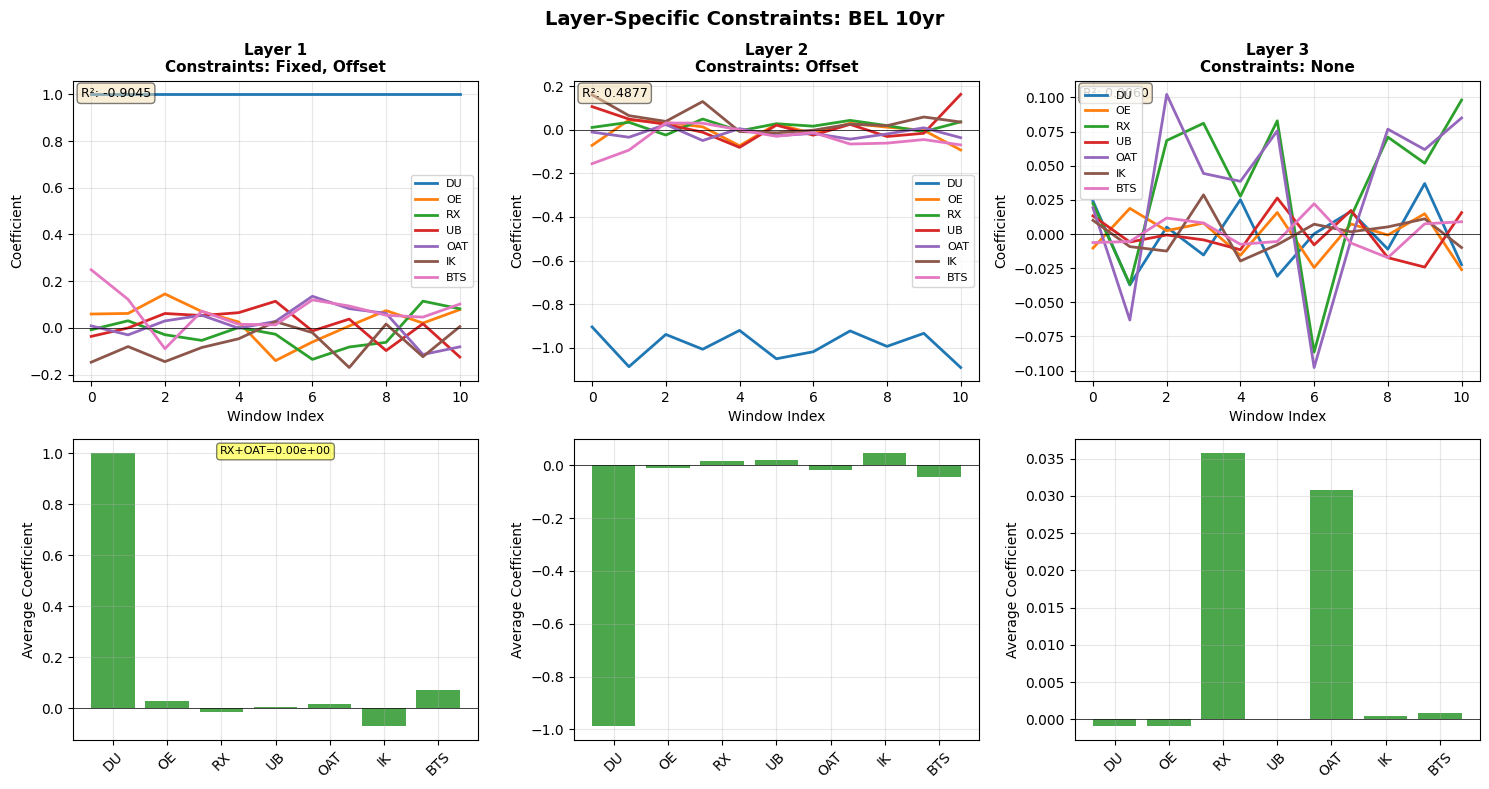


LAYER-SPECIFIC CONSTRAINT SUMMARY

Layer 1:
  method: exact
  offset_indices: (2, 4)
  fixed_constraints: [(0, 1.0), (1, 0.5)]
  Mean R²: -0.9045

Layer 2:
  method: penalty
  offset_indices: (2, 4)
  offset_penalty: 100000000.0
  zero_penalty: 10000000000.0
  Mean R²: 0.4877

Layer 3:
  No constraints
  Mean R²: 0.0060


In [20]:
def multi_layer_constrained_regression(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    method: str = 'jax',
    layer_constraints: List[Dict] = None,
    discovery_config: Optional[Dict] = None,
    cvxpy_config: Optional[Dict] = None) -> Dict:
    """
    Run layered regression with different constraints for each layer.

    Args:
        X: Input data (n_samples, n_hedges)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: Regression method
        layer_constraints: List of constraint configs, one per layer
            Example: [
                {  # Layer 1: Strong constraints
                    'method': 'exact',
                    'offset_indices': (2, 4),
                    'fixed_constraints': [(0, 1.0)]
                },
                {  # Layer 2: Relaxed constraints
                    'method': 'penalty',
                    'offset_indices': (2, 4),
                    'offset_penalty': 1e8
                },
                {  # Layer 3: No constraints
                }
            ]
        discovery_config: Configuration for discovery
        cvxpy_config: Configuration for CVXPY solver

    Returns:
        Dictionary with layered results
    """

    n_countries = 12
    n_tenors = 14
    n_samples = X.shape[0]

    if layer_constraints is None:
        layer_constraints = [{}, {}, {}]  # 3 layers, no constraints

    n_layers = len(layer_constraints)

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    print(f"\nRunning {n_layers}-layer regression with {method}")
    print("="*60)

    for layer_idx, constraints in enumerate(layer_constraints):
        print(f"\nLayer {layer_idx + 1}/{n_layers}:")
        print(f"  Constraints: {list(constraints.keys()) if constraints else 'None'}")

        # Run regression for this layer with its specific constraints
        if layer_idx == 0:
            # First layer: use original Y
            target = Y
        else:
            # Subsequent layers: use residual
            target = residual

        # Run regression with layer-specific constraints
        layer_results = unified_sliding_regression_extended(
            X=X,
            Y=target,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method=method,
            layers=None,  # Don't use built-in layering
            discovery_config=discovery_config or {'enabled': False},
            constraints_config=constraints,
            cvxpy_config=cvxpy_config
        )

        W_layer = layer_results['W_all']
        r2_layer = layer_results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        print(f"  Mean R²: {jnp.mean(r2_layer):.4f}")

        # Check constraint violations for this layer
        if 'violations' in layer_results:
            violations = layer_results['violations']
            if any(v > 1e-10 for v in violations.values()):
                print(f"  Violations: {violations}")

        # Update residual for next layer
        if layer_idx < n_layers - 1:
            # Calculate predictions from this layer
            predictions = jnp.zeros_like(residual)
            counts = jnp.zeros((n_samples, 1))

            X_wins = create_windows(X, window_size, stride)
            Y_wins = create_windows(target, window_size, stride)

            for i in range(len(W_layer)):
                start = i * stride
                end = start + window_size

                pred_window = X[start:end] @ W_layer[i]
                predictions = predictions.at[start:end].add(pred_window)
                counts = counts.at[start:end].add(1.0)

            predictions = predictions / jnp.maximum(counts, 1.0)
            residual = residual - predictions

            # Report residual size
            residual_norm = jnp.linalg.norm(residual)
            original_norm = jnp.linalg.norm(Y)
            print(f"  Residual: {residual_norm:.2f} ({100*residual_norm/original_norm:.1f}% of original)")

    # Compute total coefficients
    W_total = jnp.zeros_like(W_layers[0][0])
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_layers': W_layers,
        'W_total': W_total,
        'r2_layers': r2_layers,
        'n_layers': n_layers,
        'method': method,
        'layer_constraints': layer_constraints
    }


def create_windows(data, window_size, stride):
    """Helper function to create windows."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    windows = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows.append(data[start:end])

    return jnp.stack(windows)


# Example: Different constraints for each layer
def example_layer_specific_constraints():
    """
    Example showing different constraints for each layer.
    """

    # Generate sample data
    n_samples = 1756
    n_hedges = 7
    n_outputs = 168

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_hedges))
    Y = jax.random.normal(key, (n_samples, n_outputs))

    # Define layer-specific constraints
    layer_constraints = [
        {  # Layer 1: Strict constraints
            'method': 'exact',
            'offset_indices': (2, 4),  # RX + OAT = 0
            'fixed_constraints': [(0, 1.0), (1, 0.5)]  # DU=1.0, OE=0.5
        },
        {  # Layer 2: Relaxed constraints
            'method': 'penalty',
            'offset_indices': (2, 4),  # Still want RX + OAT = 0 but with penalty
            'offset_penalty': 1e8,
            'zero_penalty': 1e10
        },
        {  # Layer 3: No constraints, free fitting
            # Empty dict means no constraints
        }
    ]

    # Run layered regression
    results = multi_layer_constrained_regression(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='jax',
        layer_constraints=layer_constraints
    )

    return results


# For Belgium-specific layer constraints
def create_belgium_layer_constraints():
    """
    Create Belgium-specific constraints that vary by layer.
    """

    # Use wrapper to create base constraints
    base_constraints = {
        'use_only_hedges_country_tenor': {
            ('BEL', '2yr'): ['DU', 'OE'],
            ('BEL', '3yr'): ['DU', 'OE'],
            ('BEL', '4yr'): ['DU', 'OE'],
            ('BEL', '5yr'): ['DU', 'OE']
        },
        'country_constraints': {
            'BEL': [
                {'hedge': 'OAT', 'type': 'offset', 'partner': 'RX'}
            ]
        }
    }

    # Convert to layer-specific format
    layer_constraints = [
        {  # Layer 1: Apply Belgium constraints strictly
            'method': 'exact',
            'offset_indices': (4, 2),  # OAT (index 4) + RX (index 2) = 0
            # Note: zero constraints would need to be handled via discovery_mask
        },
        {  # Layer 2: Relax to allow more hedges
            'method': 'penalty',
            'offset_penalty': 1e8
        },
        {  # Layer 3: Free fitting
        }
    ]

    return layer_constraints, base_constraints


# Visualization for layer-specific constraints
def visualize_layer_constraints(
    results: Dict,
    country: str = 'BEL',
    tenor: str = '10yr',
    hedge_list: Optional[List[str]] = None) -> plt.Figure:
    """
    Visualize how constraints affect each layer.
    """

    if hedge_list is None:
        hedge_list = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']

    country_list = ['DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL', 'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN']
    tenor_list = ['2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr', '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr']

    country_idx = country_list.index(country)
    tenor_idx = tenor_list.index(tenor)
    output_idx = country_idx * len(tenor_list) + tenor_idx

    W_layers = results['W_layers']
    n_layers = results['n_layers']
    layer_constraints = results.get('layer_constraints', [{}] * n_layers)

    fig, axes = plt.subplots(2, n_layers, figsize=(5*n_layers, 8))

    for layer_idx in range(n_layers):
        # Top row: coefficients over windows
        ax_top = axes[0, layer_idx] if n_layers > 1 else axes[0]

        W_layer = W_layers[layer_idx]
        n_windows = W_layer.shape[0]
        window_indices = np.arange(n_windows)

        for hedge_idx, hedge_name in enumerate(hedge_list):
            coeffs = W_layer[:, hedge_idx, output_idx]
            if np.max(np.abs(coeffs)) > 1e-10:
                ax_top.plot(window_indices, coeffs, label=hedge_name, linewidth=2)

        # Add constraint info to title
        constraints = layer_constraints[layer_idx]
        constraint_str = []
        if 'fixed_constraints' in constraints:
            constraint_str.append('Fixed')
        if 'offset_indices' in constraints:
            constraint_str.append('Offset')
        if not constraints:
            constraint_str.append('None')

        ax_top.set_title(f'Layer {layer_idx + 1}\nConstraints: {", ".join(constraint_str)}',
                        fontsize=11, fontweight='bold')
        ax_top.set_xlabel('Window Index')
        ax_top.set_ylabel('Coefficient')
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)
        ax_top.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

        # Add R²
        if 'r2_layers' in results:
            mean_r2 = float(np.mean(results['r2_layers'][layer_idx]))
            ax_top.text(0.02, 0.98, f'R²: {mean_r2:.4f}',
                       transform=ax_top.transAxes, fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Bottom row: average coefficients as bars
        ax_bottom = axes[1, layer_idx] if n_layers > 1 else axes[1]

        W_avg_layer = np.mean(W_layer, axis=0)
        coeffs_avg = W_avg_layer[:, output_idx]

        x_pos = np.arange(len(hedge_list))
        colors = ['green' if abs(coeffs_avg[i]) > 1e-10 else 'lightgray'
                  for i in range(len(hedge_list))]

        bars = ax_bottom.bar(x_pos, coeffs_avg, color=colors, alpha=0.7)
        ax_bottom.set_xticks(x_pos)
        ax_bottom.set_xticklabels(hedge_list, rotation=45)
        ax_bottom.set_ylabel('Average Coefficient')
        ax_bottom.grid(True, alpha=0.3)
        ax_bottom.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

        # Annotate constraint violations
        if 'offset_indices' in constraints and constraints.get('method') == 'exact':
            idx1, idx2 = constraints['offset_indices']
            sum_val = coeffs_avg[idx1] + coeffs_avg[idx2]
            ax_bottom.text(0.5, 0.95, f'{hedge_list[idx1]}+{hedge_list[idx2]}={sum_val:.2e}',
                          transform=ax_bottom.transAxes, ha='center', fontsize=8,
                          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    fig.suptitle(f'Layer-Specific Constraints: {country} {tenor}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig


# Example usage
if __name__ == "__main__":
    # Run example with layer-specific constraints
    results = example_layer_specific_constraints()

    # Visualize
    fig = visualize_layer_constraints(results, country='BEL', tenor='10yr')
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("LAYER-SPECIFIC CONSTRAINT SUMMARY")
    print("="*60)

    for layer_idx, constraints in enumerate(results['layer_constraints']):
        print(f"\nLayer {layer_idx + 1}:")
        if constraints:
            for key, value in constraints.items():
                print(f"  {key}: {value}")
        else:
            print("  No constraints")

        mean_r2 = float(jnp.mean(results['r2_layers'][layer_idx]))
        print(f"  Mean R²: {mean_r2:.4f}")

In [21]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Dict, List, Tuple, Optional, Union, Any
from dataclasses import dataclass
import warnings


@dataclass
class ConstraintSpec:
    """Specification for a single constraint."""
    hedge_index: int  # Index of hedge (0-6)
    value: Optional[float]  # Value for fixed constraint, None for offset
    constraint_type: str  # 'fixed' or 'offset'
    partner_hedge_index: Optional[int] = None  # For offset constraints


class CountryTenorConstraintManager:
    """Manages constraints at country and country-tenor levels."""

    def __init__(self,
                 country_list: List[str],
                 tenor_list: List[str],
                 hedge_list: List[str]):
        """
        Initialize the constraint manager.

        Args:
            country_list: List of country codes
            tenor_list: List of tenor labels
            hedge_list: List of hedge names
        """
        self.country_list = country_list
        self.tenor_list = tenor_list
        self.hedge_list = hedge_list

        self.n_countries = len(country_list)
        self.n_tenors = len(tenor_list)
        self.n_hedges = len(hedge_list)
        self.n_outputs = self.n_countries * self.n_tenors

        # Create mapping dictionaries
        self.country_to_idx = {c: i for i, c in enumerate(country_list)}
        self.tenor_to_idx = {t: i for i, t in enumerate(tenor_list)}
        self.hedge_to_idx = {h: i for i, h in enumerate(hedge_list)}

        # Initialize constraint storage
        self.country_constraints = {}  # {country: [ConstraintSpec, ...]}
        self.country_tenor_constraints = {}  # {(country, tenor): [ConstraintSpec, ...]}

    def add_country_constraint(self,
                              country: str,
                              hedge: Union[str, int],
                              constraint_type: str = 'fixed',
                              value: Optional[float] = None,
                              partner_hedge: Optional[Union[str, int]] = None):
        """
        Add a constraint for all tenors of a country.

        Args:
            country: Country code
            hedge: Hedge name or index
            constraint_type: 'fixed' or 'offset'
            value: Value for fixed constraint
            partner_hedge: Partner hedge for offset constraint
        """
        if country not in self.country_to_idx:
            raise ValueError(f"Country {country} not in country list")

        hedge_idx = self._get_hedge_index(hedge)
        partner_idx = self._get_hedge_index(partner_hedge) if partner_hedge is not None else None

        constraint = ConstraintSpec(
            hedge_index=hedge_idx,
            value=value,
            constraint_type=constraint_type,
            partner_hedge_index=partner_idx
        )

        if country not in self.country_constraints:
            self.country_constraints[country] = []
        self.country_constraints[country].append(constraint)

    def add_country_tenor_constraint(self,
                                   country: str,
                                   tenor: str,
                                   hedge: Union[str, int],
                                   constraint_type: str = 'fixed',
                                   value: Optional[float] = None,
                                   partner_hedge: Optional[Union[str, int]] = None):
        """
        Add a constraint for a specific country-tenor combination.

        Args:
            country: Country code
            tenor: Tenor label
            hedge: Hedge name or index
            constraint_type: 'fixed' or 'offset'
            value: Value for fixed constraint
            partner_hedge: Partner hedge for offset constraint
        """
        if country not in self.country_to_idx:
            raise ValueError(f"Country {country} not in country list")
        if tenor not in self.tenor_to_idx:
            raise ValueError(f"Tenor {tenor} not in tenor list")

        hedge_idx = self._get_hedge_index(hedge)
        partner_idx = self._get_hedge_index(partner_hedge) if partner_hedge is not None else None

        constraint = ConstraintSpec(
            hedge_index=hedge_idx,
            value=value,
            constraint_type=constraint_type,
            partner_hedge_index=partner_idx
        )

        key = (country, tenor)
        if key not in self.country_tenor_constraints:
            self.country_tenor_constraints[key] = []
        self.country_tenor_constraints[key].append(constraint)

    def _get_hedge_index(self, hedge: Optional[Union[str, int]]) -> Optional[int]:
        """Convert hedge name to index."""
        if hedge is None:
            return None
        if isinstance(hedge, str):
            if hedge not in self.hedge_to_idx:
                raise ValueError(f"Hedge {hedge} not in hedge list")
            return self.hedge_to_idx[hedge]
        return hedge

    def _get_output_index(self, country_idx: int, tenor_idx: int) -> int:
        """Get the output index for a country-tenor pair."""
        return country_idx * self.n_tenors + tenor_idx

    def build_constraint_configs(self) -> Dict[str, Any]:
        """
        Build constraint configuration for the regression functions.

        Returns:
            Dictionary with constraint configurations compatible with
            unified_sliding_regression_extended
        """
        # Collect all constraints with their affected outputs
        fixed_constraints_dict = {}  # {(hedge_idx, output_idx): value}
        offset_constraints_dict = {}  # {(hedge1_idx, hedge2_idx): [output_indices]}

        # Process country-level constraints
        for country, constraints in self.country_constraints.items():
            country_idx = self.country_to_idx[country]

            for constraint in constraints:
                # Apply to all tenors of this country
                for tenor_idx in range(self.n_tenors):
                    output_idx = self._get_output_index(country_idx, tenor_idx)

                    # Check if overridden by country-tenor constraint
                    if self._is_overridden(country, self.tenor_list[tenor_idx], constraint):
                        continue

                    if constraint.constraint_type == 'fixed':
                        key = (constraint.hedge_index, output_idx)
                        fixed_constraints_dict[key] = constraint.value
                    elif constraint.constraint_type == 'offset':
                        key = (constraint.hedge_index, constraint.partner_hedge_index)
                        if key not in offset_constraints_dict:
                            offset_constraints_dict[key] = []
                        offset_constraints_dict[key].append(output_idx)

        # Process country-tenor constraints (these override country-level)
        for (country, tenor), constraints in self.country_tenor_constraints.items():
            country_idx = self.country_to_idx[country]
            tenor_idx = self.tenor_to_idx[tenor]
            output_idx = self._get_output_index(country_idx, tenor_idx)

            for constraint in constraints:
                if constraint.constraint_type == 'fixed':
                    key = (constraint.hedge_index, output_idx)
                    fixed_constraints_dict[key] = constraint.value
                elif constraint.constraint_type == 'offset':
                    key = (constraint.hedge_index, constraint.partner_hedge_index)
                    if key not in offset_constraints_dict:
                        offset_constraints_dict[key] = []
                    offset_constraints_dict[key].append(output_idx)

        # Convert to format expected by regression functions
        return self._format_constraints_for_regression(
            fixed_constraints_dict,
            offset_constraints_dict
        )

    def _is_overridden(self, country: str, tenor: str, constraint: ConstraintSpec) -> bool:
        """Check if a country-level constraint is overridden by a country-tenor constraint."""
        key = (country, tenor)
        if key not in self.country_tenor_constraints:
            return False

        # Check if any country-tenor constraint affects the same hedge
        for ct_constraint in self.country_tenor_constraints[key]:
            if ct_constraint.hedge_index == constraint.hedge_index:
                return True
            if (constraint.constraint_type == 'offset' and
                ct_constraint.constraint_type == 'offset' and
                ct_constraint.partner_hedge_index == constraint.partner_hedge_index):
                return True

        return False

    def _format_constraints_for_regression(self,
                                          fixed_dict: Dict,
                                          offset_dict: Dict) -> Dict[str, Any]:
        """
        Format constraints for the regression functions.

        This creates output-specific constraints that can be applied
        during the regression.
        """
        # For methods that support output-specific constraints
        constraints_config = {
            'method': 'exact',  # or 'penalty'
            'output_specific_fixed': fixed_dict,
            'output_specific_offset': offset_dict,
            'fixed_constraints': [],  # Will be populated per window
            'offset_indices': []  # Will be populated per window
        }

        # For methods that don't support output-specific constraints,
        # we'll need to handle this differently (see build_window_constraints)

        return constraints_config

    def build_window_constraints(self, output_indices: Optional[np.ndarray] = None) -> Dict[str, Any]:
        """
        Build constraints for a specific window of outputs.

        Args:
            output_indices: Indices of outputs in this window (optional)

        Returns:
            Constraint configuration for this window
        """
        if output_indices is None:
            # Use all outputs
            output_indices = np.arange(self.n_outputs)

        # This would be used for methods that need per-window constraint setup
        # Implementation depends on specific regression method requirements
        pass

    def create_discovery_mask(self,
                            zero_hedges: Optional[Dict[str, List[str]]] = None,
                            zero_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None) -> jnp.ndarray:
        """
        Create a discovery mask for zero constraints.

        Args:
            zero_hedges: {country: [hedge_names]} for country-level zeros
            zero_country_tenor: {(country, tenor): [hedge_names]} for specific zeros

        Returns:
            Boolean mask of shape (n_hedges, n_outputs)
        """
        mask = jnp.zeros((self.n_hedges, self.n_outputs), dtype=bool)

        if zero_hedges:
            for country, hedges in zero_hedges.items():
                if country not in self.country_to_idx:
                    continue
                country_idx = self.country_to_idx[country]

                for hedge in hedges:
                    hedge_idx = self._get_hedge_index(hedge)
                    # Apply to all tenors of this country
                    for tenor_idx in range(self.n_tenors):
                        output_idx = self._get_output_index(country_idx, tenor_idx)
                        mask = mask.at[hedge_idx, output_idx].set(True)

        if zero_country_tenor:
            for (country, tenor), hedges in zero_country_tenor.items():
                if country not in self.country_to_idx or tenor not in self.tenor_to_idx:
                    continue

                country_idx = self.country_to_idx[country]
                tenor_idx = self.tenor_to_idx[tenor]
                output_idx = self._get_output_index(country_idx, tenor_idx)

                for hedge in hedges:
                    hedge_idx = self._get_hedge_index(hedge)
                    mask = mask.at[hedge_idx, output_idx].set(True)

        return mask


def country_tenor_regression_wrapper(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    method: str = 'jax',
    country_constraints: Optional[Dict[str, List[Dict]]] = None,
    country_tenor_constraints: Optional[Dict[Tuple[str, str], List[Dict]]] = None,
    zero_constraints_country: Optional[Dict[str, List[str]]] = None,
    zero_constraints_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None,
    use_only_hedges_country: Optional[Dict[str, List[str]]] = None,
    use_only_hedges_country_tenor: Optional[Dict[Tuple[str, str], List[str]]] = None,
    discovery_enabled: bool = True,
    discovery_config: Optional[Dict] = None,
    cvxpy_config: Optional[Dict] = None,
    constraint_method: str = 'exact',
    **kwargs) -> Dict:
    """
    Wrapper function for country-tenor constrained regression.

    Args:
        X: Input data (n_samples, n_hedges=7)
        Y: Output data (n_samples, n_outputs=168)
        window_size: Size of sliding window (e.g., 200)
        stride: Stride for sliding window (e.g., 150)
        method: Regression method ('jax', 'cvxpy', 'vectorized', 'hybrid')

        country_constraints: Dictionary of country-level constraints
            Example: {
                'DEU': [
                    {'hedge': 'DU', 'type': 'fixed', 'value': 1.0},
                    {'hedge': 'OE', 'type': 'offset', 'partner': 'RX'}
                ],
                'FRA': [
                    {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
                ]
            }

        country_tenor_constraints: Dictionary of country-tenor specific constraints
            Example: {
                ('DEU', '10yr'): [
                    {'hedge': 'DU', 'type': 'fixed', 'value': 1.5}
                ],
                ('ITA', '30yr'): [
                    {'hedge': 'BTS', 'type': 'offset', 'partner': 'IK'}
                ]
            }

        zero_constraints_country: Hedges to zero for entire countries
            Example: {'GRC': ['DU', 'OE']}

        zero_constraints_country_tenor: Hedges to zero for specific country-tenors
            Example: {('PRT', '50yr'): ['RX', 'UB']}

        use_only_hedges_country: Use ONLY these hedges for countries (zero all others)
            Example: {'ITA': ['IK', 'BTS']}  # Italy uses only IK and BTS

        use_only_hedges_country_tenor: Use ONLY these hedges for specific country-tenors
            Example: {('ESP', '30yr'): ['OAT', 'BTS']}

        discovery_enabled: Whether to use automatic discovery
        discovery_config: Configuration for discovery
        cvxpy_config: Configuration for CVXPY solver
        constraint_method: 'exact' (KKT) or 'penalty' for JAX method
        **kwargs: Additional arguments passed to regression function

    Returns:
        Results dictionary from unified_sliding_regression_extended
    """

    # Initialize lists
    country_list = ['DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL', 'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN']
    tenor_list = ['2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr', '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr']
    hedge_list = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']

    # Validate dimensions
    n_countries = len(country_list)
    n_tenors = len(tenor_list)
    n_hedges = len(hedge_list)
    n_outputs = n_countries * n_tenors

    assert X.shape[1] == n_hedges, f"X should have {n_hedges} features (hedges), got {X.shape[1]}"
    assert Y.shape[1] == n_outputs, f"Y should have {n_outputs} outputs, got {Y.shape[1]}"

    # Initialize constraint manager
    manager = CountryTenorConstraintManager(country_list, tenor_list, hedge_list)

    # Convert "use only" constraints to zero constraints
    # Process use_only constraints by creating zero constraints for all OTHER hedges
    if use_only_hedges_country:
        if zero_constraints_country is None:
            zero_constraints_country = {}

        for country, allowed_hedges in use_only_hedges_country.items():
            # Find hedges to zero out (all except the allowed ones)
            hedges_to_zero = [h for h in hedge_list if h not in allowed_hedges]

            if country in zero_constraints_country:
                # Merge with existing zero constraints
                existing = set(zero_constraints_country[country])
                existing.update(hedges_to_zero)
                zero_constraints_country[country] = list(existing)
            else:
                zero_constraints_country[country] = hedges_to_zero

    if use_only_hedges_country_tenor:
        if zero_constraints_country_tenor is None:
            zero_constraints_country_tenor = {}

        for (country, tenor), allowed_hedges in use_only_hedges_country_tenor.items():
            # Find hedges to zero out (all except the allowed ones)
            hedges_to_zero = [h for h in hedge_list if h not in allowed_hedges]

            key = (country, tenor)
            if key in zero_constraints_country_tenor:
                # Merge with existing zero constraints
                existing = set(zero_constraints_country_tenor[key])
                existing.update(hedges_to_zero)
                zero_constraints_country_tenor[key] = list(existing)
            else:
                zero_constraints_country_tenor[key] = hedges_to_zero

    # Add country-level constraints
    if country_constraints:
        for country, constraints in country_constraints.items():
            for constraint in constraints:
                if constraint['type'] == 'fixed':
                    manager.add_country_constraint(
                        country=country,
                        hedge=constraint['hedge'],
                        constraint_type='fixed',
                        value=constraint['value']
                    )
                elif constraint['type'] == 'offset':
                    manager.add_country_constraint(
                        country=country,
                        hedge=constraint['hedge'],
                        constraint_type='offset',
                        partner_hedge=constraint['partner']
                    )

    # Add country-tenor specific constraints
    if country_tenor_constraints:
        for (country, tenor), constraints in country_tenor_constraints.items():
            for constraint in constraints:
                if constraint['type'] == 'fixed':
                    manager.add_country_tenor_constraint(
                        country=country,
                        tenor=tenor,
                        hedge=constraint['hedge'],
                        constraint_type='fixed',
                        value=constraint['value']
                    )
                elif constraint['type'] == 'offset':
                    manager.add_country_tenor_constraint(
                        country=country,
                        tenor=tenor,
                        hedge=constraint['hedge'],
                        constraint_type='offset',
                        partner_hedge=constraint['partner']
                    )

    # Create discovery mask for zero constraints
    discovery_mask = None
    if zero_constraints_country or zero_constraints_country_tenor:
        discovery_mask = manager.create_discovery_mask(
            zero_hedges=zero_constraints_country,
            zero_country_tenor=zero_constraints_country_tenor
        )

    # Build constraint configuration
    constraints_config_full = manager.build_constraint_configs()

    # For the current implementation, we need to adapt to output-agnostic constraints
    # This is a simplified version that applies the most common constraints
    fixed_constraints = []
    offset_indices = None

    # Extract the most common fixed constraint (simplified for now)
    if constraints_config_full.get('output_specific_fixed'):
        # Find the most common fixed constraint across outputs
        fixed_dict = constraints_config_full['output_specific_fixed']
        if fixed_dict:
            # Group by hedge index and value
            hedge_value_counts = {}
            for (hedge_idx, output_idx), value in fixed_dict.items():
                key = (hedge_idx, value)
                if key not in hedge_value_counts:
                    hedge_value_counts[key] = 0
                hedge_value_counts[key] += 1

            # Use the most common one
            if hedge_value_counts:
                most_common = max(hedge_value_counts.items(), key=lambda x: x[1])
                hedge_idx, value = most_common[0]
                fixed_constraints = [(hedge_idx, value)]

    # Extract the most common offset constraint (simplified for now)
    if constraints_config_full.get('output_specific_offset'):
        offset_dict = constraints_config_full['output_specific_offset']
        if offset_dict:
            # Find the most common offset pair
            offset_counts = {}
            for (hedge1_idx, hedge2_idx), outputs in offset_dict.items():
                offset_counts[(hedge1_idx, hedge2_idx)] = len(outputs)

            if offset_counts:
                most_common = max(offset_counts.items(), key=lambda x: x[1])
                offset_indices = most_common[0]

    # Prepare discovery configuration
    if discovery_config is None:
        discovery_config = {}

    discovery_config['enabled'] = discovery_enabled
    if discovery_mask is not None:
        discovery_config['forced_mask'] = discovery_mask

    # Prepare constraints configuration
    constraints_config = {
        'method': constraint_method,
        'fixed_constraints': fixed_constraints if fixed_constraints else None,
        'offset_indices': offset_indices
    }

    # Add penalty parameters if using penalty method
    if constraint_method == 'penalty':
        constraints_config.update({
            'zero_penalty': kwargs.pop('zero_penalty', 1e12),
            'offset_penalty': kwargs.pop('offset_penalty', 1e10),
            'fixed_penalty': kwargs.pop('fixed_penalty', 1e10)
        })

    # Call the main regression function
    results = unified_sliding_regression_extended(
        X=X,
        Y=Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=constraints_config,
        cvxpy_config=cvxpy_config,
        **kwargs
    )

    # Add constraint manager to results for reference
    results['constraint_manager'] = manager
    results['country_list'] = country_list
    results['tenor_list'] = tenor_list
    results['hedge_list'] = hedge_list

    return results


def create_output_specific_regression(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    constraint_manager: CountryTenorConstraintManager,
    method: str = 'jax',
    **kwargs) -> Dict:
    """
    Advanced version that handles output-specific constraints properly.
    This requires modifying the underlying regression to handle per-output constraints.

    This is a more complex implementation that would require changes to the
    base regression functions to properly handle output-specific constraints.
    """
    # This would require significant modifications to the base functions
    # to handle constraints that vary by output dimension
    pass


# Example usage functions
def example_country_tenor_constraints():
    """Example demonstrating the wrapper usage."""

    # Generate example data
    n_samples = 1756
    n_hedges = 7
    n_countries = 12
    n_tenors = 14
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_hedges))
    Y = jax.random.normal(key, (n_samples, n_outputs))

    # Example 1: Simple country-level constraints
    print("Example 1: Country-level constraints")
    results1 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='jax',
        country_constraints={
            'DEU': [
                {'hedge': 'DU', 'type': 'fixed', 'value': 1.0},
                {'hedge': 'OE', 'type': 'offset', 'partner': 'RX'}
            ],
            'FRA': [
                {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
            ]
        },
        zero_constraints_country={
            'GRC': ['BTS', 'IK']  # Zero out BTS and IK for Greece
        }
    )

    # Example 2: Mixed country and country-tenor constraints
    print("\nExample 2: Mixed constraints with country-tenor overrides")
    results2 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='jax',
        country_constraints={
            'ITA': [
                {'hedge': 'BTS', 'type': 'fixed', 'value': 0.8}
            ]
        },
        country_tenor_constraints={
            ('ITA', '30yr'): [
                {'hedge': 'BTS', 'type': 'fixed', 'value': 1.2}  # Override for 30yr
            ],
            ('ESP', '2yr'): [
                {'hedge': 'DU', 'type': 'offset', 'partner': 'UB'}
            ]
        },
        zero_constraints_country_tenor={
            ('PRT', '50yr'): ['RX', 'OE']  # Zero specific hedges for PRT 50yr
        }
    )

    # Example 3: Using CVXPY with advanced constraints
    print("\nExample 3: CVXPY with transaction costs")
    results3 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='cvxpy',
        country_constraints={
            'EUR': [
                {'hedge': 'DU', 'type': 'fixed', 'value': 0.5},
                {'hedge': 'OAT', 'type': 'fixed', 'value': 0.5}
            ]
        },
        cvxpy_config={
            'loss': 'huber',
            'huber_delta': 1.0,
            'dv01_neutral': True  # Sum of coefficients = 1
        }
    )

    # Example 4: Use only specific hedges for countries
    print("\nExample 4: Italy uses ONLY IK and BTS hedges")
    results4 = country_tenor_regression_wrapper(
        X=X,
        Y=Y,
        window_size=200,
        stride=150,
        method='vectorized',
        use_only_hedges_country={
            'ITA': ['IK', 'BTS'],  # Italy uses ONLY these two hedges
            'ESP': ['BTS', 'OAT']   # Spain uses ONLY these two hedges
        },
        use_only_hedges_country_tenor={
            ('GRC', '30yr'): ['DU']  # Greece 30yr uses ONLY DU
        },
        discovery_config={'enabled': False}
    )

    return results1, results2, results3, results4


def create_constraint_report(results: Dict) -> str:
    """
    Create a report of applied constraints and their satisfaction.

    Args:
        results: Results from country_tenor_regression_wrapper

    Returns:
        String report of constraints
    """
    report = []
    report.append("="*80)
    report.append("CONSTRAINT REPORT")
    report.append("="*80)

    manager = results.get('constraint_manager')
    if not manager:
        return "No constraint manager found in results"

    # Report country-level constraints
    if manager.country_constraints:
        report.append("\nCOUNTRY-LEVEL CONSTRAINTS:")
        for country, constraints in manager.country_constraints.items():
            report.append(f"\n  {country}:")
            for c in constraints:
                hedge_name = manager.hedge_list[c.hedge_index]
                if c.constraint_type == 'fixed':
                    report.append(f"    - {hedge_name} = {c.value}")
                else:
                    partner_name = manager.hedge_list[c.partner_hedge_index]
                    report.append(f"    - {hedge_name} + {partner_name} = 0")

    # Report country-tenor constraints
    if manager.country_tenor_constraints:
        report.append("\nCOUNTRY-TENOR SPECIFIC CONSTRAINTS:")
        for (country, tenor), constraints in manager.country_tenor_constraints.items():
            report.append(f"\n  {country} {tenor}:")
            for c in constraints:
                hedge_name = manager.hedge_list[c.hedge_index]
                if c.constraint_type == 'fixed':
                    report.append(f"    - {hedge_name} = {c.value}")
                else:
                    partner_name = manager.hedge_list[c.partner_hedge_index]
                    report.append(f"    - {hedge_name} + {partner_name} = 0")

    # Report violations
    violations = results.get('violations', {})
    if violations:
        report.append("\nCONSTRAINT VIOLATIONS:")
        for key, value in violations.items():
            if value > 1e-10:
                report.append(f"  {key}: {value:.2e}")

    # Report R² summary
    if 'r2' in results:
        report.append(f"\nMODEL PERFORMANCE:")
        report.append(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")

    return "\n".join(report)


if __name__ == "__main__":
    # Run examples
    print("Running country-tenor constraint examples...")
    results = example_country_tenor_constraints()

    # Print report for first example
    print("\n" + create_constraint_report(results[0]))

Running country-tenor constraint examples...
Example 1: Country-level constraints

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 1: Discovering zero patterns...
  Discovered 37 zeros (3.1% sparsity)

Phase 2: Applying jax regression...

Completed in 22.653 seconds
  Zero violations: max=1.00e+00, count=37
  Offset violations: max=0.00e+00
  Fixed violations: max=0.00e+00
  Mean R²: -0.9012

Example 2: Mixed constraints with country-tenor overrides

Unified Sliding Regression Extended
  Method: jax
  Data: 1756 samples, 7 features, 168 outputs
  Windows: 11 (size 200, stride 150)

Phase 1: Discovering zero patterns...
  Discovered 12 zeros (1.0% sparsity)

Phase 2: Applying jax regression...

Completed in 22.414 seconds
  Zero violations: max=8.00e-01, count=12
  Offset violations: max=0.00e+00
  Fixed violations: max=1.19e-07
  Mean R²: -0.5933

Example 3: CVXPY with transaction costs

Unified